# Boosting Loan Conversions: A Predictive Modeling Approach in Fintech Marketing

Personal loans have become a cornerstone of modern financial services, offering individuals the flexibility to finance significant life events, such as home renovations, education, or unexpected expenses. In recent years, fintech companies have leveraged data-driven strategies to revolutionize the lending process, making it more accessible and tailored to customers' needs. 

As competition in the financial sector intensifies, understanding customer behavior and predicting their loan acceptance has become crucial for growth. By harnessing machine learning and advanced analytics, fintechs are better equipped to make targeted, effective marketing strategies and offer products that meet customers' specific financial situations.

## Problem Definition

A fast-growing fintech has a predominantly passive customer base, with 90.6% holding fixed-income investments and only a small fraction using credit. To expand its loan portfolio, the bank seeks to convert passive customers into personal loan borrowers. A previous liability insurance campaign achieved a 9.4% conversion rate, motivating the retail marketing team to develop more targeted strategies.

In this project, I will analyze customer behavior and predict personal loan acceptance using data. I will use R for Exploratory Data Analysis (EDA) and data preparation, ensuring the dataset is properly cleaned and structured for modeling. Machine learning models will be implemented in Python, leveraging powerful libraries such as Scikit-learn, TensorFlow, and Keras. Success will be measured by the predictive model's accuracy and its effectiveness in optimizing future marketing efforts.

## Getting Started

### Settings and Libraries

In [21]:
# Setting Options
options(warn = -1)
options(repr.matrix.max.cols = 1000, repr.matrix.max.rows = 10)
options(scipen = 999)
options(width = 999)
options(repr.plot.width = 11, repr.plot.height = 6)
options(jupyter.plot_scale = 1)

# Loading Libraries
suppressPackageStartupMessages({
  library(conflicted)
  library(tidyverse)
  library(DataExplorer)
  library(DMwR)
  library(gridExtra)
  library(GGally)
  library(caret)
  library(MASS)
  library(readxl)
  library(car)
  library(rpart)
  library(rattle)
  library(rpart.plot)
  library(RColorBrewer)
  library(leaps)
  library(VIM)
  library(ggplot2)
  library(psych)
  library(skimr)
  library(EnvStats)
  library(robustbase)
})

conflict_prefer("select", "dplyr")
conflict_prefer("filter", "dplyr")
conflict_prefer("boxcox", "EnvStats")

[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::select over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::filter over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer EnvStats::boxcox over any other package.


### Loading the Data

In [ ]:
file_name <- "../_data/universal-bank.csv"
df <- read.csv(file_name)

## Exploratory Data Analysis 01

In [ ]:
skim(df) |> print()

── Data Summary ────────────────────────
                           Values
Name                       df    
Number of rows             5000  
Number of columns          14    
_______________________          
Column type frequency:           
  numeric                  14    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

To improve data visualization and ensure a more accurate representation of the data, I made some prior adjustments. One of the first changes was removing the identification column (ID) and the Geospatial component (ZIP.Code), as the geospatial data will not be explored in this study. Additionally, all of the columns were originally treated as numeric, which was not entirely accurate for some variables.

To correct this, I transformed several variables to categorical types, including Personal Loan, Family, Education, SecuritiesAccount, CDAccount, Online, and CreditCard (the explanation of each variable will be provided later in the text.). While the Family variable could technically be considered numerical, it was preferable to transform it into a categorical, as it has a small range (from 1 to 4). Treating it as a categorical variable allows the model to interpret the data more effectively, especially when considering it in the context of group comparisons rather than as a continuous scale. This transformation will also help simplify the analysis and improve model interpretability.

── Data Summary ────────────────────────
                           Values
Name                       df    
Number of rows             5000  
Number of columns          12    
_______________________          
Column type frequency:           
  factor                   7     
  numeric                  5     
________________________         
Group variables            None  

── Variable type: factor ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

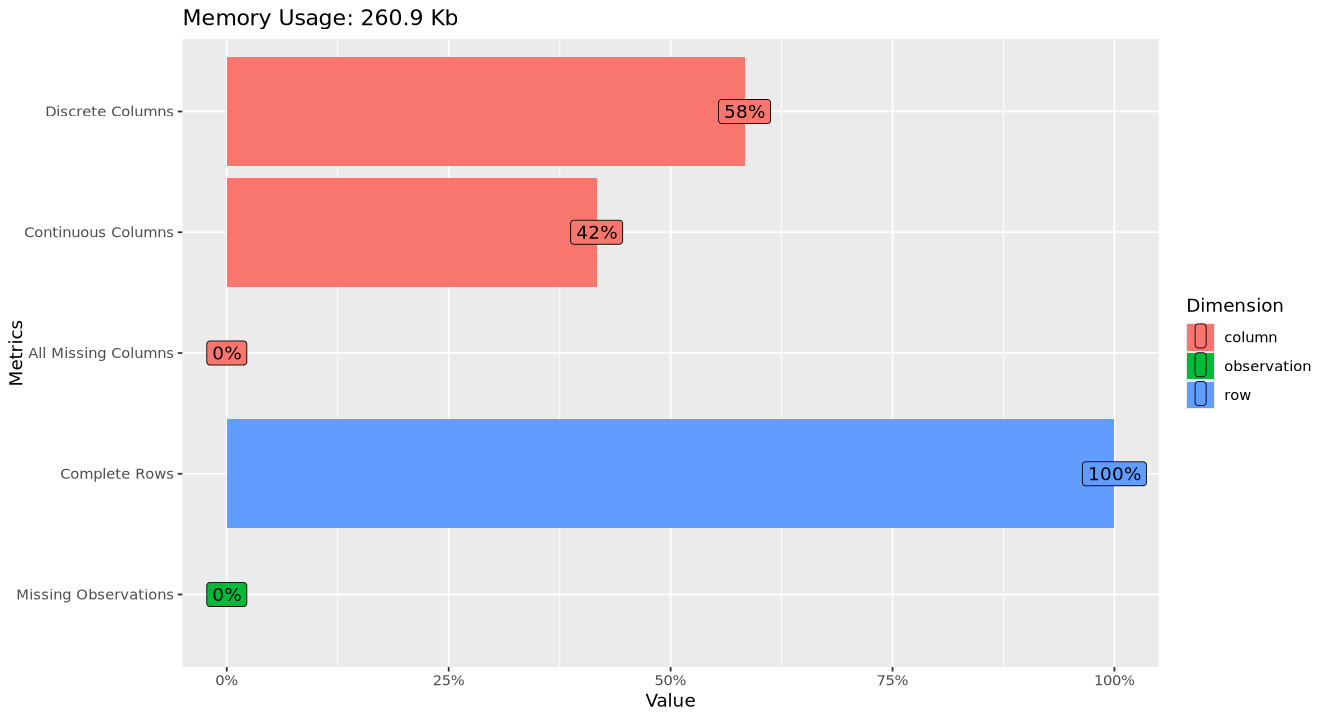

In [ ]:
# Format Transformation
df <- df |>
  dplyr::select(-c(ID, ZIP.Code)) |>
  dplyr::mutate(across(c(PersonalLoan,
                         Family,
                         Education,
                         SecuritiesAccount,
                         CDAccount,
                         Online,
                         CreditCard),
                       as.factor)) |>
  dplyr::select(PersonalLoan, everything())

skim(df) |> print()
plot_intro(df)

The dataset consists of 58% discrete columns and 42% continuous columns, offering a balanced mix of categorical and numerical features, which will be important for feature engineering and model selection. Moreover, there are no columns with entirely missing values, and every row is fully complete, meaning there are no missing observations. 

### Data Quality Analysis

Starting with an examination of the dataset's structure and quality, as shown in the below images, the data is well-structured and complete.

This high data quality eliminates the need for extensive cleaning, allowing me to focus directly on feature selection, transformation, and building predictive models in the next steps.

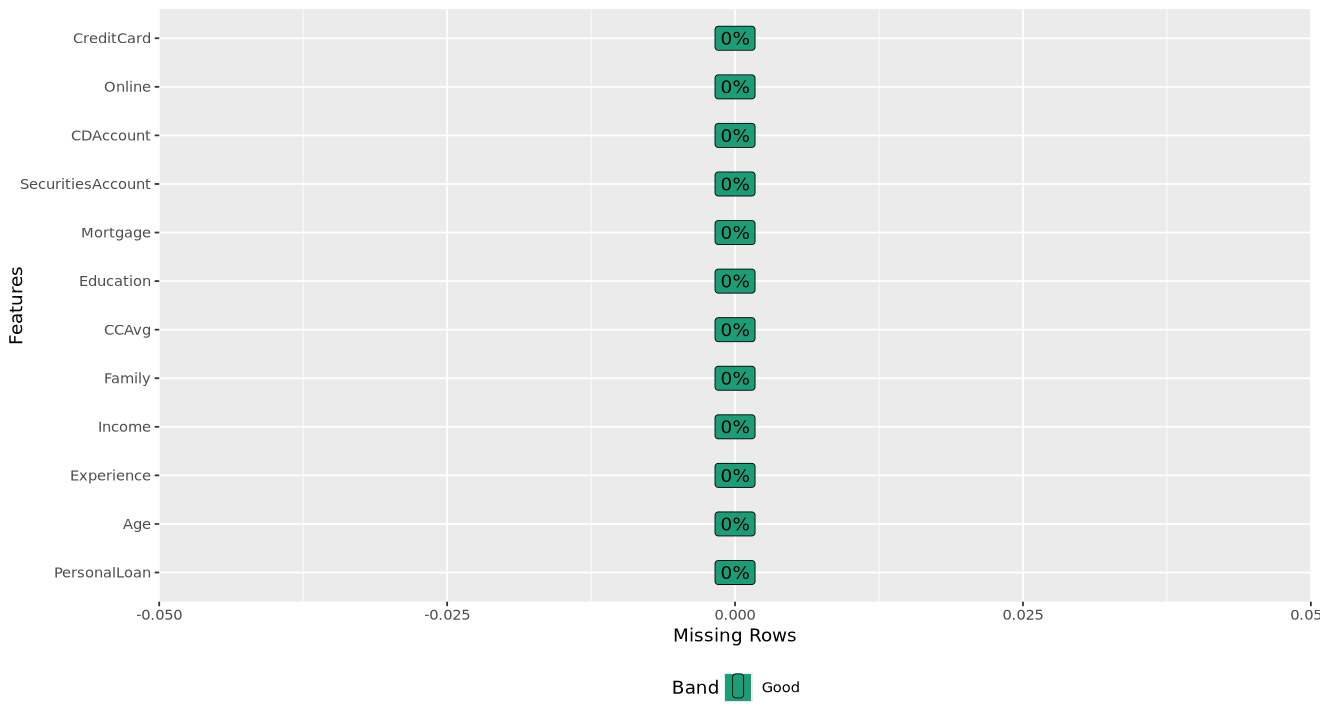

In [ ]:
plot_missing(df)

Now, let's take a closer look at outliers. The criterion used for identifying outliers was any value falling below or above three standard deviations from the mean. As we can see in the plot below, CCAvg, Mortgage, and Income exhibit some outliers.

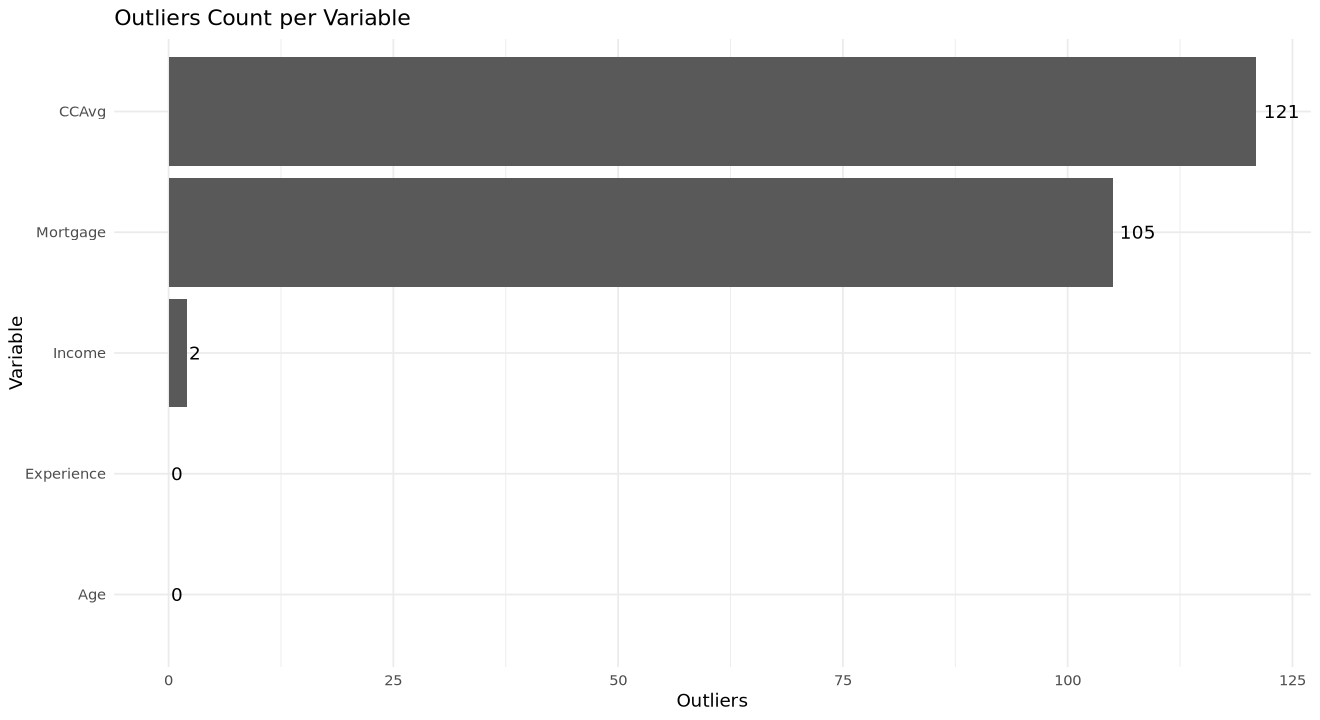

In [ ]:
# Aplica o scale e conta os outliers
scaled_df <- scale(df[, sapply(df, is.numeric)])
outliers <- abs(scaled_df) > 3

# Conta os outliers por coluna
outlier_counts <- colSums(outliers)

# Cria um data frame com as variáveis e a contagem de outliers
outlier_df <- data.frame(
  Variable = names(outlier_counts),
  Outliers = outlier_counts
)

outlier_df$Variable <- reorder(outlier_df$Variable,
  outlier_df$Outliers,
  FUN = sum
)

# Plota o gráfico de barras usando ggplot2
ggplot(outlier_df, aes(x = Variable, y = Outliers)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = Outliers), hjust = -0.2, color = "black") +
  coord_flip() +
  labs(x = "Variable", y = "Outliers", title = "Outliers Count per Variable") +
  theme_minimal()

### Univariate Analysis

We begin by exploring the categorical columns. Categorical features typically represent distinct groups or categories, and understanding their distribution is crucial for identifying potential patterns or imbalances in the data. 

The bar plots for each categorical column provide a visual representation of the frequency distribution across different categories, helping us identify any dominant categories or underrepresented ones. By analyzing these distributions, we can better understand the structure of the data, which will inform decisions about feature encoding and model design.

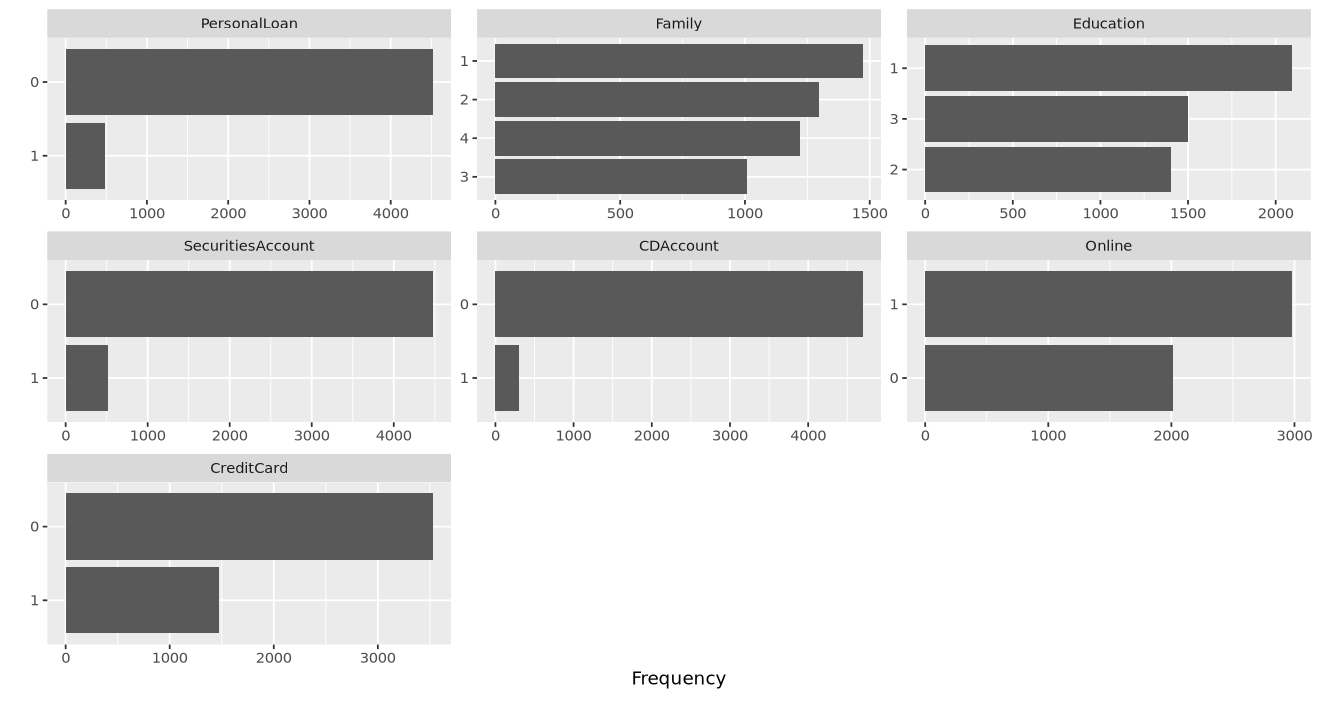

In [ ]:
plot_bar(df)

1. PersonalLoan: This binary variable indicates whether a customer accepted a personal loan. The dataset shows a significant class imbalance, with 4,520 customers not accepting the loan and only 480 accepting it. This imbalance is crucial for modeling, as it may affect the performance of the machine learning algorithms, particularly when it comes to correctly predicting the minority class, which, in this case, is our target variable. Addressing this imbalance will be an important step in model optimization.

2. Family: This variable represents the number of family members, with four possible categories: 1 (1,472 customers), 2 (1,296 customers), 3 (1,010 customers), and 4 (1,222 customers).

3. Education: This categorical variable represents the education level of customers, with three categories: 1 (2,096 customers), 2 (1,403 customers), and 3 (1,501 customers). The distribution is relatively balanced.

4. SecuritiesAccount: A binary variable indicating whether a customer holds a securities account. Only 522 customers (10.44%) have a securities account.

5. CDAccount: This binary variable represents whether a customer holds a certificate of deposit (CD) account, with 302 customers (6.04%) having a CD account.

6. Online: This variable indicates whether a customer uses online banking, with 2,984 customers (59.68%) using online banking services.

7. CreditCard: A binary variable indicating whether a customer holds a credit card, with 1,470 customers (29.4%) possessing a credit card.

Next, we turn our attention to the numerical columns. A histogram is an effective way to visualize the distribution of these continuous variables, as it shows the frequency of data points within different ranges. By examining the histograms for each numerical column, we can identify patterns such as skewness, the presence of multiple peaks, or any outliers that may require further attention. The following histograms provide insights into the distribution of the numerical features, which will help guide the decisions for feature scaling, transformation, and modeling.

Age: -0.03
Experience: -0.03
Income: 0.84
CCAvg: 1.6
Mortgage: 2.1


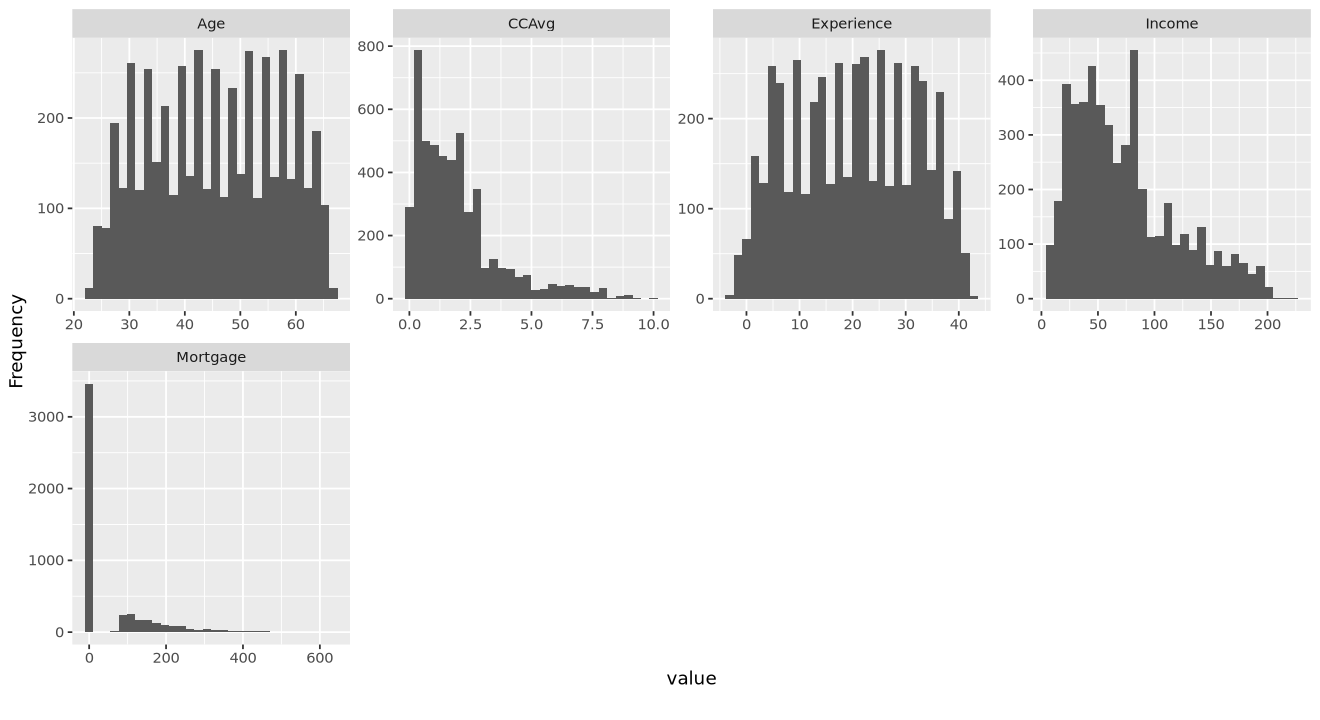

In [ ]:
plot_histogram(df)

# Calcula skewness para todas as colunas numéricas e gera textos formatados
skew_text <- map_chr(names(df), function(col) {
  if (is.numeric(df[[col]])) {
    paste0(col, ": ", round(skewness(df[[col]], na.rm = TRUE), 2))
  } else {
    NA
  }
})

skew_text <- na.omit(skew_text)

cat(skew_text, sep = '\n')

1. Age: The average age of customers is 45.3 years, with a standard deviation of 11.5 years. Most customers are between 35 and 55 years old.

2. CCAvg (Credit Card Average): The average amount spent on credit cards is 1.94, with a large variation (standard deviation of 1.75). Most customers spend below 2 on their credit cards.

3. Experience: The average customer experience is 20.1 years, with a standard deviation of 11.5 years. There are some negative values, potentially indicating incorrect data or a missing value issue.

4. Income: The average income is 73.8k, with a standard deviation of 46.0k. Most customers have incomes between 39k and 98k, although there are a few customers with much higher earnings.

5. Mortgage: The average mortgage amount is 56.5k, with many customers having no mortgage at all. The distribution is right-skewed, with a few customers holding larger mortgage amounts.

CCAvg and Mortgage exhibit skewed distributions (1.6 and 2.1, respectively), while Income is slightly skewed but still less than 1, so we can consider it normal. Age and Experience show a more balanced distribution. Understanding these distributions, along with the presence of outliers, is essential for feature engineering and selecting the appropriate models.

### Bivariate Analysis

We begin by exploring the relationship between the target variable, PersonalLoan, and the numerical features. A boxplot is a great tool for visualizing the distribution of numerical data across different categories, allowing us to compare the spread, central tendency, and presence of outliers for each group. By plotting the numerical features against PersonalLoan, we can gain insights into how these variables differ between customers who accepted a personal loan and those who did not.

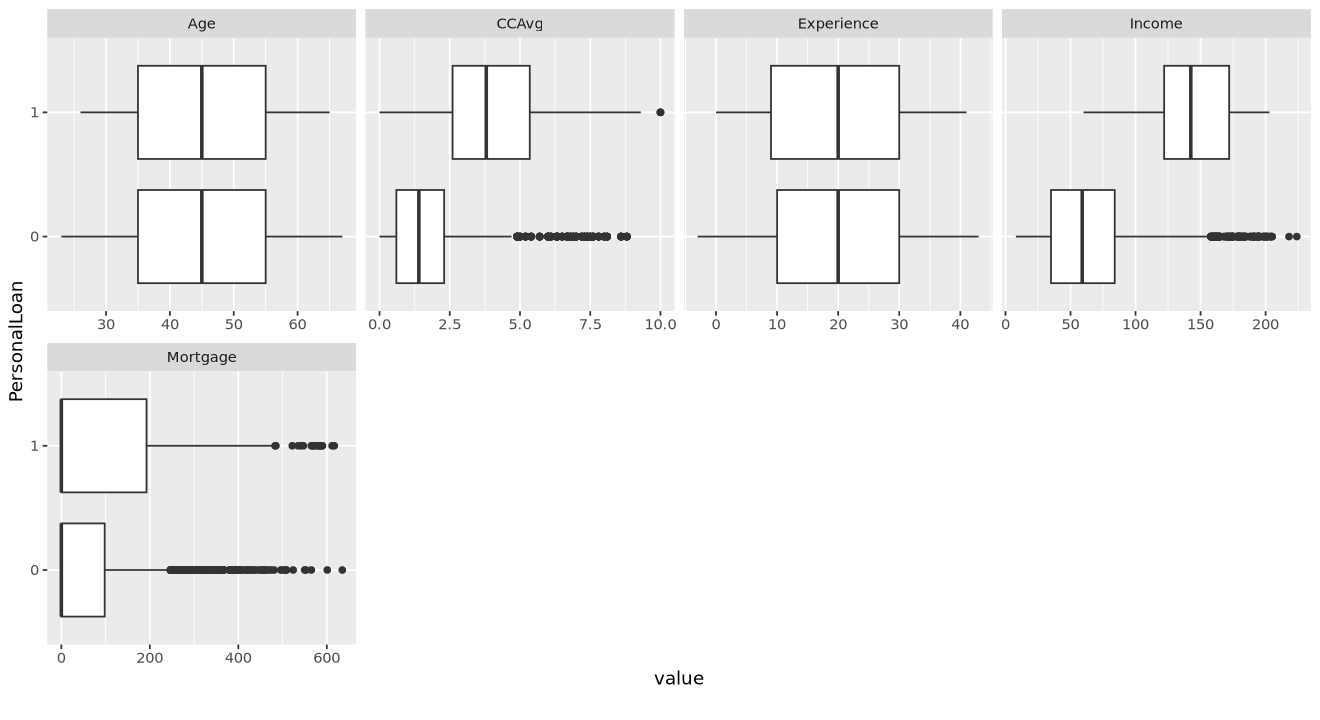

In [ ]:
plot_boxplot(df, by = "PersonalLoan")

From the visualizations, two variables stand out as potentially strong predictors of personal loan acceptance: CCAvg (Credit Card Average) and Income.

Regarding CCAvg, the boxplot clearly reveals a distinct separation between the two groups: customers who accepted the loan (PersonalLoan = 1) and those who did not (PersonalLoan = 0). Customers who accepted a personal loan generally had higher CCAvg values. This suggests that individuals with higher credit card usage or spending habits are more likely to engage with financial products such as personal loans. It implies that customers who are more active in managing their credit might be more receptive to the idea of taking out a loan, possibly due to their familiarity with financial transactions and credit behavior.

For Income, the analysis also showed notable differences in the distribution between the two groups. Higher-income individuals were more likely to accept personal loans, while lower-income individuals were less inclined to do so. This finding is intuitive, as individuals with higher incomes generally have more financial flexibility and a greater capacity to handle additional debt, making them more likely to consider loan options.

Following the boxplot, we now turn our attention to a stacked bar plot that visualizes the relationship between PersonalLoan and the categorical variables. In this plot, we use percentages to make it easier to compare the distribution of categorical features within each group of the target variable - those who accepted the personal loan and those who did not. By analyzing this plot, we can gain insights into how factors such as family size, education level, and other categorical attributes differ between the two groups, which will help us better understand the characteristics that may influence loan acceptance.

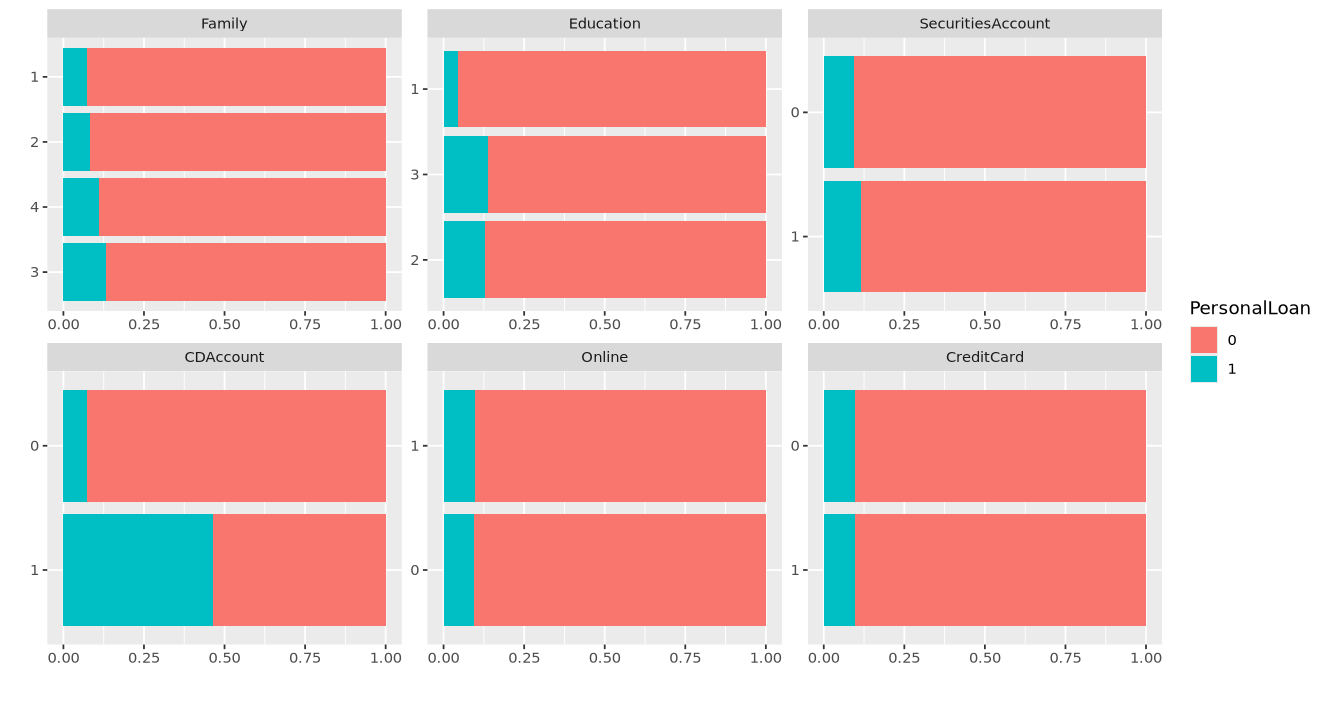

In [ ]:
plot_bar(df, by = "PersonalLoan")

When analyzing the stacked bar plot by PersonalLoan, several key observations can be made:
Concerning Family Size, there is a subtle yet noticeable distinction between the percentage of people who accepted the loan across different family sizes. As family size increases, the likelihood of taking the personal loan appears to rise. This suggests that individuals from larger families may have different financial needs or behaviors, which could make them more inclined to consider taking out a loan. Larger families might face higher financial pressures, prompting them to seek additional financial support to cover expenses.

Looking at Education, the distinction between group 2 and group 3 is minimal when compared to group 1 in terms of loan acceptance rates. This indicates that both group 2 and group 3 exhibit similar loan acceptance patterns, with a noticeable difference when compared to group 1. Given this, it may be beneficial to combine groups 2 and 3 for further analysis, simplifying the model without losing valuable insights.

When considering CDAccount, the data reveals a clear distinction between the groups. Customers who have a Certificate of Deposit Account (CDAccount = 1) show significantly higher loan acceptance rates. This suggests that individuals with a CDAccount are more financially engaged or have a stronger relationship with the bank, making them more likely to accept a loan offer. Customers with a CDAccount may already be familiar with the bank's services and have trust in its financial products, which increases their likelihood of accepting the loan.

Next, we analyze the relationships between the numerical variables using a correlation matrix. A correlation matrix helps to identify potential linear relationships between variables, showing how strongly each feature is related to others. By visualizing these relationships, we can detect patterns, multicollinearity, or redundant features that may influence the modeling process. The following plot presents the correlation matrix, which will guide us in feature selection and model refinement.

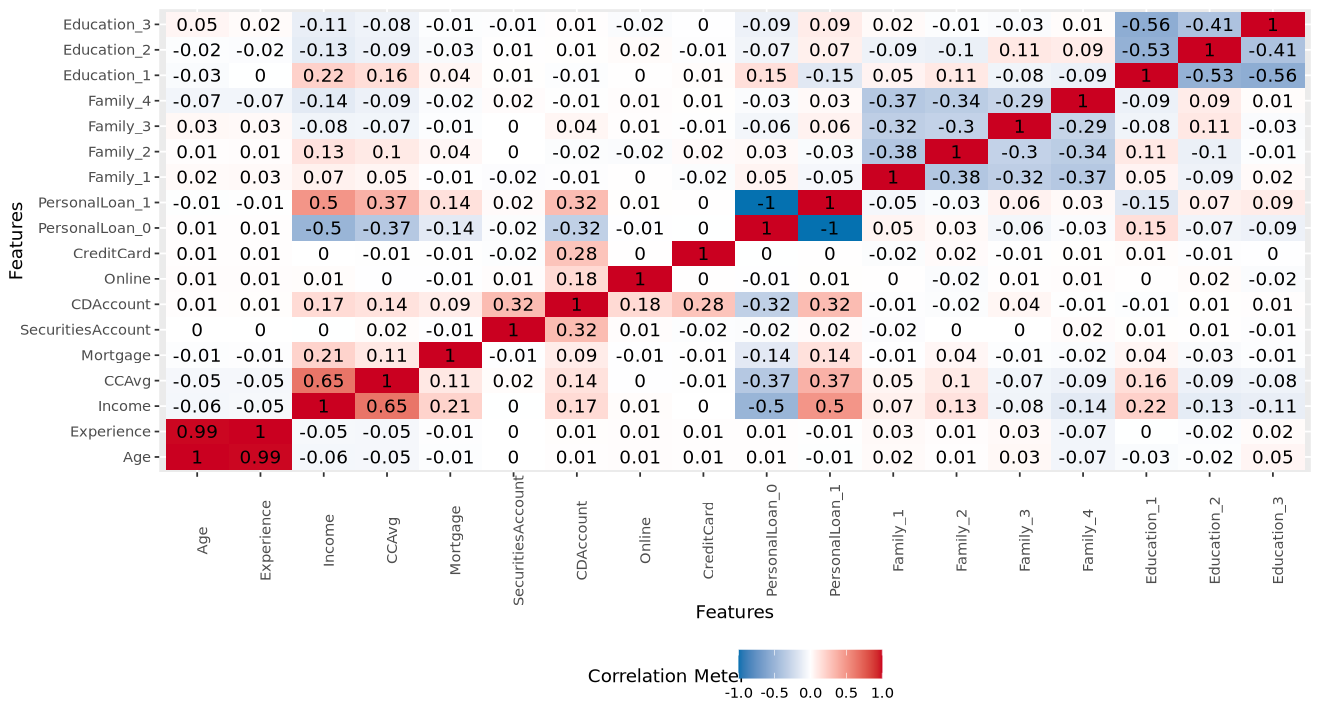

In [ ]:
df |>
  mutate(across(c(
    SecuritiesAccount,
    CDAccount,
    Online,
    CreditCard
  ), as.numeric)) |>
plot_correlation()

The correlation matrix plot further reinforces the observations made during the exploratory analysis. It confirms that CCAvg (Credit Card Average), Income, and CDAccount are strong predictors of personal loan acceptance, showing notable correlations with the target variable. These relationships suggest that these features will play a crucial role in the predictive model. 

Additionally, the high correlation between Age and Experience, as well as between CCAvg and Income, indicates potential multicollinearity issues that should be carefully addressed. The approach to handling these issues will depend on the final model choice, as some algorithms, like linear regression, are more sensitive to multicollinearity than others, such as tree-based models.

## Data Preparation

Below is a structured plan for the Data Preparation phase based on previous analysis:

1. Data Cleaning: handling missing values and outliers.
2. Feature Engineering: One-hot encoding, feature binning.
3. Data Transformation: scaling and normalizing continuous variables, evaluate and treat multicollinearity.
4. Imbalance: handling imbalanced categorical variables.

### Data Cleaning

The dataset used for this analysis is fully complete, with no missing values. As a result, no imputation or removal of data points was necessary. Regarding outliers, they will not be treated at this stage. The columns containing outliers are also the same ones exhibiting significant skewness, which will be addressed later through appropriate transformations. Therefore, the decision was made to assess the impact of outliers after applying the necessary transformations to these skewed features.

### Feature Engineering

The first step in feature engineering will be to one-hot encode the categorical multiclass variables. One-hot encoding is essential for converting these categorical features into a format that can be understood by machine learning models, as they typically require numerical input. By creating binary columns for each category, the model will be able to interpret the different classes without imposing any ordinal relationship. This transformation ensures that each category is represented independently, allowing the model to capture the nuances of each class effectively.

In [ ]:
y <- data.frame(PersonalLoan = df$PersonalLoan)
x <- df |>
  dplyr::select(-PersonalLoan)

x_cats <- x[, sapply(x, is.factor)]
x_nums <- x[, sapply(x, is.numeric)]

x_binary <- x_cats[, sapply(x_cats, function(col) length(unique(col)) == 2)]
x_multi <- x_cats[, sapply(x_cats, function(col) length(unique(col)) > 2)]

x_multi <- dummify(x_multi) |>
  mutate(across(everything(), as.factor))

df <- cbind(y, x_nums, x_binary, x_multi)

tail(df)

,PersonalLoan,Age,Experience,Income,CCAvg,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2,Education_3
,<fct>,<int>,<int>,<int>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
4995,0,64,40,75,2.0,0,0,0,1,0,0,0,1,0,0,0,1
4996,0,29,3,40,1.9,0,0,0,1,0,1,0,0,0,0,0,1
4997,0,30,4,15,0.4,85,0,0,1,0,0,0,0,1,1,0,0
4998,0,63,39,24,0.3,0,0,0,0,0,0,1,0,0,0,0,1
4999,0,65,40,49,0.5,0,0,0,1,0,0,0,1,0,0,1,0
5000,0,28,4,83,0.8,0,0,0,1,1,0,0,1,0,1,0,0


After performing one-hot encoding, we will apply binning to the "Education" variable. Upon analyzing the distribution of "PersonalLoan" across different education groups, it became apparent that Group 2 and Group 3 show very similar patterns in terms of loan acceptance ([Check it here](#bivariate-analysis)). To simplify the model and reduce dimensionality, we will combine these two groups into a single category. This binning process will help the model focus on the most significant distinctions, improving interpretability without sacrificing predictive power.

In [ ]:
df$Education_2 <- as.numeric(df$Education_2) + as.numeric(df$Education_3) - 2
df <- df |>
  select(-Education_3) |>
  mutate(Education_2 = factor(Education_2))

tail(df)

,PersonalLoan,Age,Experience,Income,CCAvg,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2
,<fct>,<int>,<int>,<int>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
4995,0,64,40,75,2.0,0,0,0,1,0,0,0,1,0,0,1
4996,0,29,3,40,1.9,0,0,0,1,0,1,0,0,0,0,1
4997,0,30,4,15,0.4,85,0,0,1,0,0,0,0,1,1,0
4998,0,63,39,24,0.3,0,0,0,0,0,0,1,0,0,0,1
4999,0,65,40,49,0.5,0,0,0,1,0,0,0,1,0,0,1
5000,0,28,4,83,0.8,0,0,0,1,1,0,0,1,0,1,0


In predictive modeling, multicollinearity—when two or more features are highly correlated—can be problematic, especially for linear models. It can distort coefficient estimates, making it difficult to interpret feature importance and reducing model stability.

In my dataset, the Experience column is highly correlated with Age, showing a near-perfect correlation of 0.99. Since these two features provide almost identical information, keeping both would be redundant and could introduce multicollinearity issues in linear models.

To address this, I considered possible solutions such as Principal Component Analysis (PCA), which transforms correlated features into uncorrelated principal components. However, given that this situation involves only two variables with an extremely high correlation, applying PCA would be unnecessary complexity. Instead, the simplest and most effective approach is to remove Experience entirely, as Age already captures the same underlying information.

This decision ensures that my dataset remains well-structured for all types of models, including linear ones, without introducing unnecessary transformations.

In [ ]:
df <- df |>
  select(-Experience)

tail(df)

,PersonalLoan,Age,Income,CCAvg,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2
,<fct>,<int>,<int>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
4995,0,64,75,2.0,0,0,0,1,0,0,0,1,0,0,1
4996,0,29,40,1.9,0,0,0,1,0,1,0,0,0,0,1
4997,0,30,15,0.4,85,0,0,1,0,0,0,0,1,1,0
4998,0,63,24,0.3,0,0,0,0,0,0,1,0,0,0,1
4999,0,65,49,0.5,0,0,0,1,0,0,0,1,0,0,1
5000,0,28,83,0.8,0,0,0,1,1,0,0,1,0,1,0


### Data Transformation

The next step in the process will be to apply scaling to the numerical features. Scaling, or normalization, ensures that all numerical features are on a similar scale, typically with a mean of 0 and a standard deviation of 1. This step prevents features with larger scales from dominating the model, and ensures that algorithms, especially those based on distance (e.g., KNN, SVM), perform effectively. However, scaling does not address the skewness of the data, so after this step, we will visualize the histograms of each numerical feature to assess their distribution.

If any variables remain skewed, we will apply a Box-Cox transformation to normalize their distribution. The Box-Cox transformation helps correct for skewness by stabilizing the variance and making the data more symmetric. This transformation is particularly beneficial for algorithms that assume a normal distribution of the input data, as it helps in making the relationships between the variables more linear and improving the model's accuracy and interpretability. Additionally, normalization and transformations like Box-Cox help in achieving faster convergence in optimization algorithms, reducing the risk of model bias caused by uneven feature distributions.

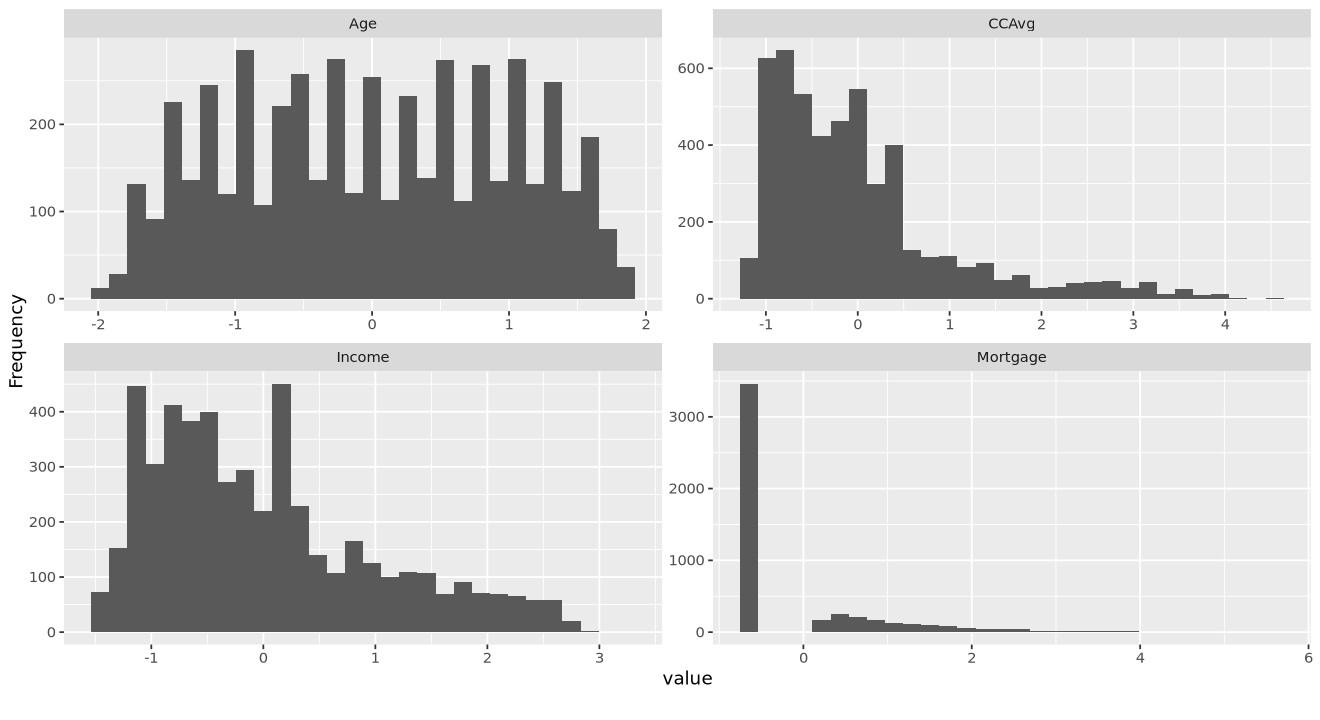

In [ ]:
x <- df |>
  dplyr::select(-PersonalLoan)

x_nums <- x[, sapply(x, is.numeric)]
df[, colnames(x_nums)] <- scale(x_nums)
plot_histogram(df, ncol = 2)

In our analysis, we observed that most clients do not have a mortgage, resulting in a large number of records where the "Mortgage" value equals 0. To simplify the model and make the feature more informative, we will discretize the "Mortgage" column. After discretization, clients will be categorized into two groups: those who have a mortgage (1) and those who do not (0).

,PersonalLoan,Age,Income,CCAvg,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2
,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
4995,0,1.627962,0.0266283,0.0355115,0,0,0,1,0,0,0,1,0,0,1
4996,0,-1.425296,-0.7336838,-0.0217079,0,0,0,1,0,1,0,0,0,0,1
4997,0,-1.338060,-1.2767638,-0.8799989,1,0,0,1,0,0,0,0,1,1,0
4998,0,1.540726,-1.0812550,-0.9372183,0,0,0,0,0,0,1,0,0,0,1
4999,0,1.715198,-0.5381750,-0.8227795,0,0,0,1,0,0,0,1,0,0,1
5000,0,-1.512532,0.2004139,-0.6511213,0,0,0,1,1,0,0,1,0,1,0


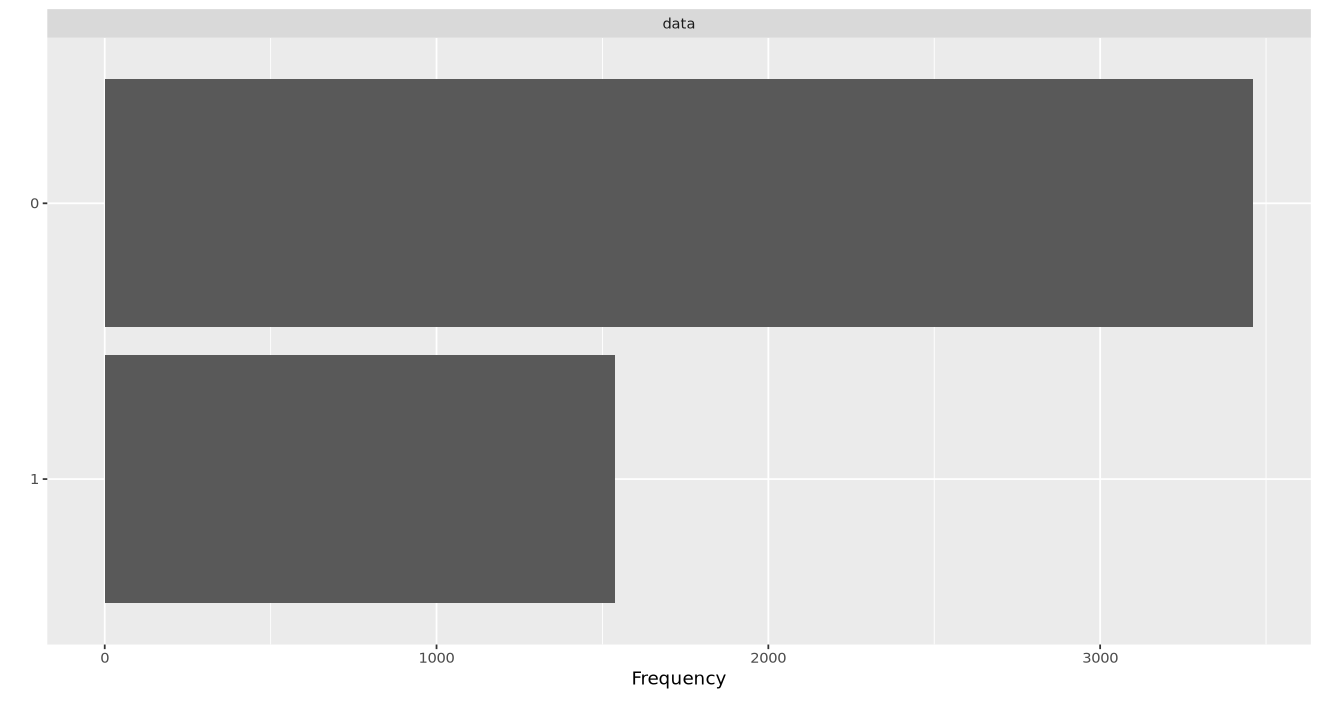

In [ ]:
df_mortgage <- read.csv(file_name) |> select(Mortgage)
df$Mortgage <- factor(ifelse(df_mortgage$Mortgage == 0, 0, 1))

tail(df)
plot_bar(df$Mortgage)

Additionally, the "CCAvg" variable is highly skewed with a skewness value of 1.6. To address this, we will explore potential transformations to normalize its distribution. Using the Box-Cox function, we will evaluate different transformation options and select the one that best reduces the skewness, making the data more suitable for modeling.

In [ ]:
min(df$CCAvg)
boxcox(df$CCAvg + 1.11)

[1] -1.108877


Results of Box-Cox Transformation
---------------------------------

Objective Name:                  PPCC

Data:                            df$CCAvg + 1.11

Sample Size:                     5000

 lambda      PPCC
   -2.0 0.3530982
   -1.5 0.3549092
   -1.0 0.3710696
   -0.5 0.5017917
    0.0 0.9069482
    0.5 0.9900687
    1.0 0.9205260
    1.5 0.8310348
    2.0 0.7493133

During the exploration of the "CCAvg" variable, we observed that the minimum value is -1.11. This is important because the Box-Cox transformation only accepts positive values. To address this, we shifted the values of "CCAvg" to ensure all values are positive. After this adjustment, we applied the Box-Cox transformation to determine the most appropriate transformation for normalizing the distribution.

The Box-Cox function suggests that the best transformation for "CCAvg" is the squared root (sqrt), as the optimal lambda value was found to be 0.5. This indicates that taking the sqrt of the values will best normalize the distribution and reduce skewness.

[1] "Before: 1.59844333666787"

[1] "After: 0.443677877831508"

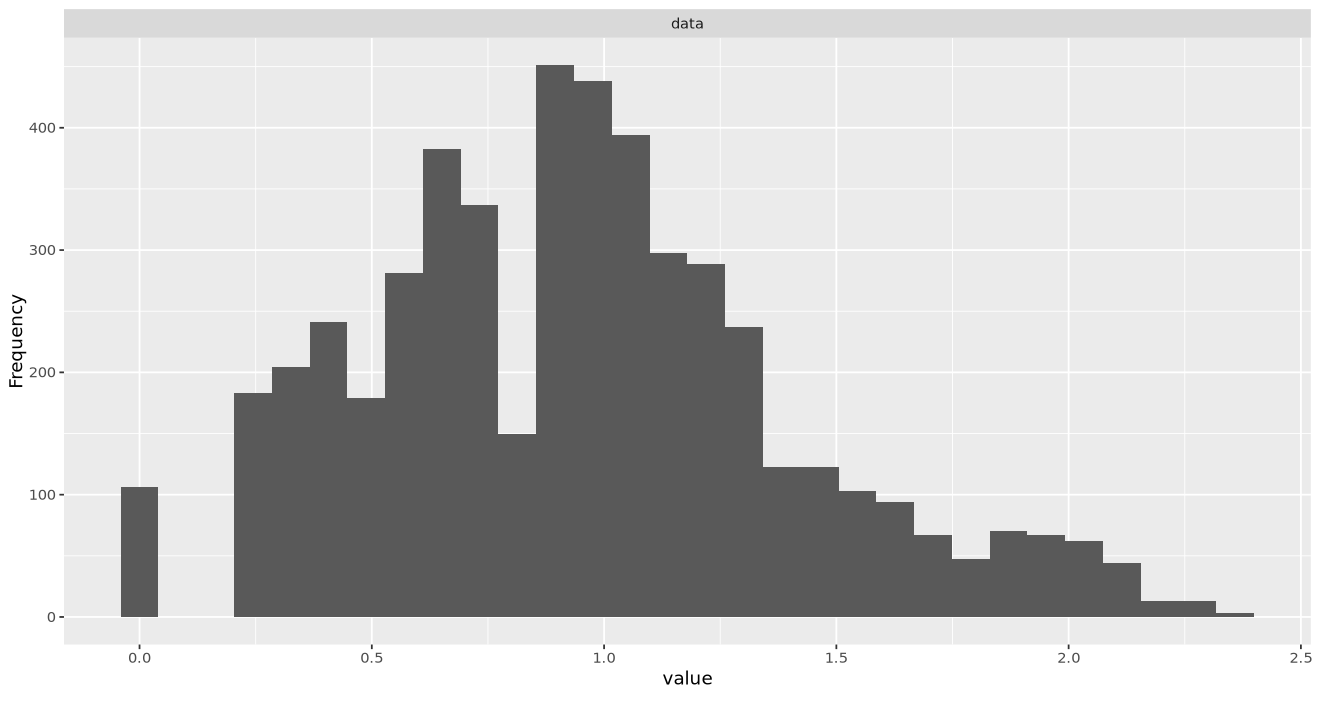

In [ ]:
paste0("Before: ", skewness(df$CCAvg))

df$CCAvg <- sqrt(df$CCAvg + 1.11)

paste0("After: ", skewness(df$CCAvg))

plot_histogram(df$CCAvg)

### Imbalance

To address the class imbalance in the PersonalLoan variable, we applied the Synthetic Minority Over-sampling Technique (SMOTE) from the DMwR package in R. SMOTE generates synthetic samples for the minority class by interpolating between existing observations, rather than simply duplicating them. This helps create a more balanced dataset while preserving variability. We set perc.over = 200, meaning that the minority class was oversampled by 200% (creating two new synthetic instances for each original one), and perc.under = 150, which undersampled the majority class to maintain a balanced distribution. This preprocessing step ensures that the model is better equipped to learn patterns from both classes, improving its ability to correctly predict loan acceptance.

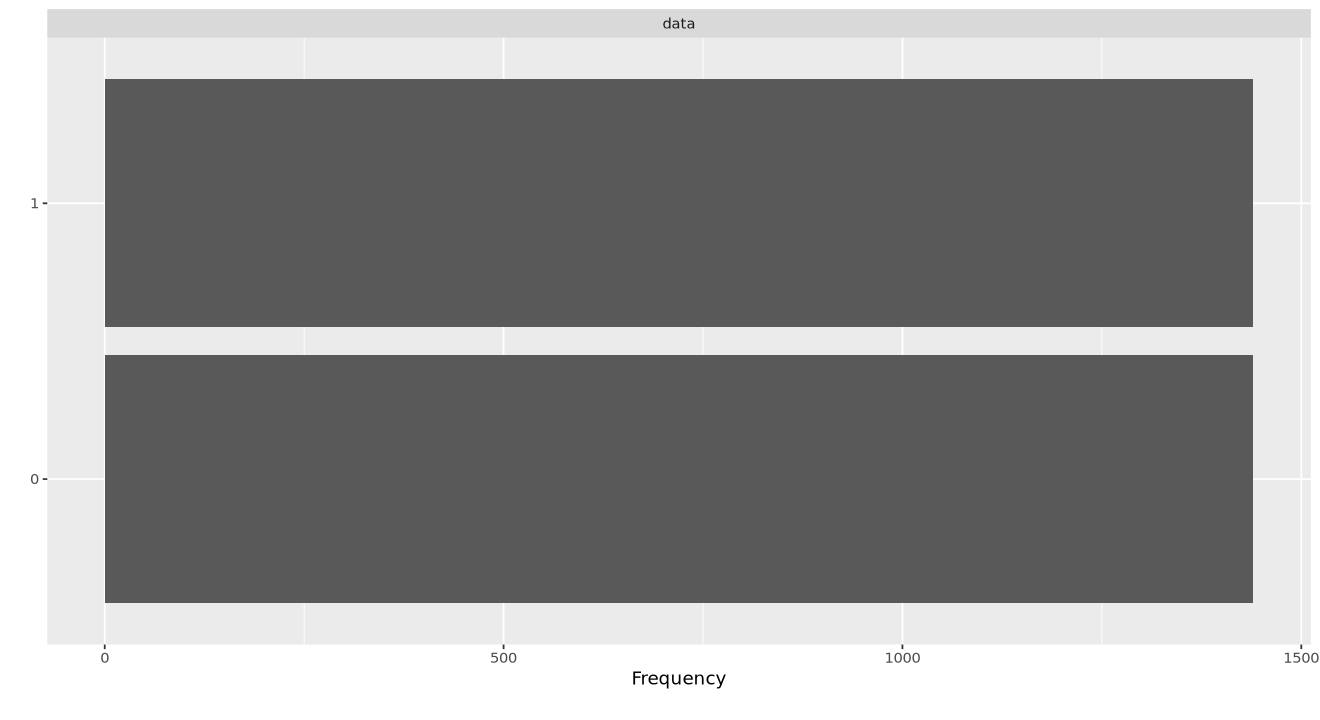

In [ ]:
df <- SMOTE(PersonalLoan ~ ., df, perc.over = 200, perc.under = 150, seed = 1)
plot_bar(df$PersonalLoan)

After applying SMOTE, we visualized the updated class distributions with bar plots. The PersonalLoan variable is now balanced, ensuring that the model receives an equal representation of both classes, which should enhance its predictive performance. Additionally, we observed an improvement in the distribution of other previously imbalanced categorical variables, such as CDAccount, CreditCard, and SecuritiesAccount. This effect occurs because SMOTE generates synthetic samples for the minority class while also applying undersampling to the majority class, indirectly influencing the distribution of other categorical variables. As a result, the dataset is now better structured for training a machine learning model, reducing potential biases and improving generalization.

## Exploratory Data Analysis 02

Before diving into machine learning, it is essential to validate that the dataset is well-structured, clean, and free of inconsistencies. In this second phase of Exploratory Data Analysis (EDA), I will assess data quality, inspect distributions, and analyze feature frequencies to ensure the transformations applied have prepared the data effectively for predictive modeling.

By examining missing values, outliers, and feature distributions, I aim to confirm that the dataset accurately represents customer behavior without introducing biases or distortions. This step is crucial, as well-prepared data enhances model performance and ensures that insights derived from predictions are both reliable and actionable.

In [ ]:
skim(df) |> print()

── Data Summary ────────────────────────
                           Values
Name                       df    
Number of rows             2880  
Number of columns          15    
_______________________          
Column type frequency:           
  factor                   12    
  numeric                  3     
________________________         
Group variables            None  

── Variable type: factor ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### Data Quality

To ensure the integrity of the dataset, I reviewed missing values after applying transformations. The generated plot confirms that no missing values are present, aligning with expectations since the original dataset had none. While this result was anticipated, performing this check was crucial to verify that no inconsistencies were introduced during data preprocessing. Even minor errors in transformations could lead to unintended data loss, potentially impacting model performance. This validation step reinforces the reliability of the dataset, ensuring it remains complete and ready for further analysis.

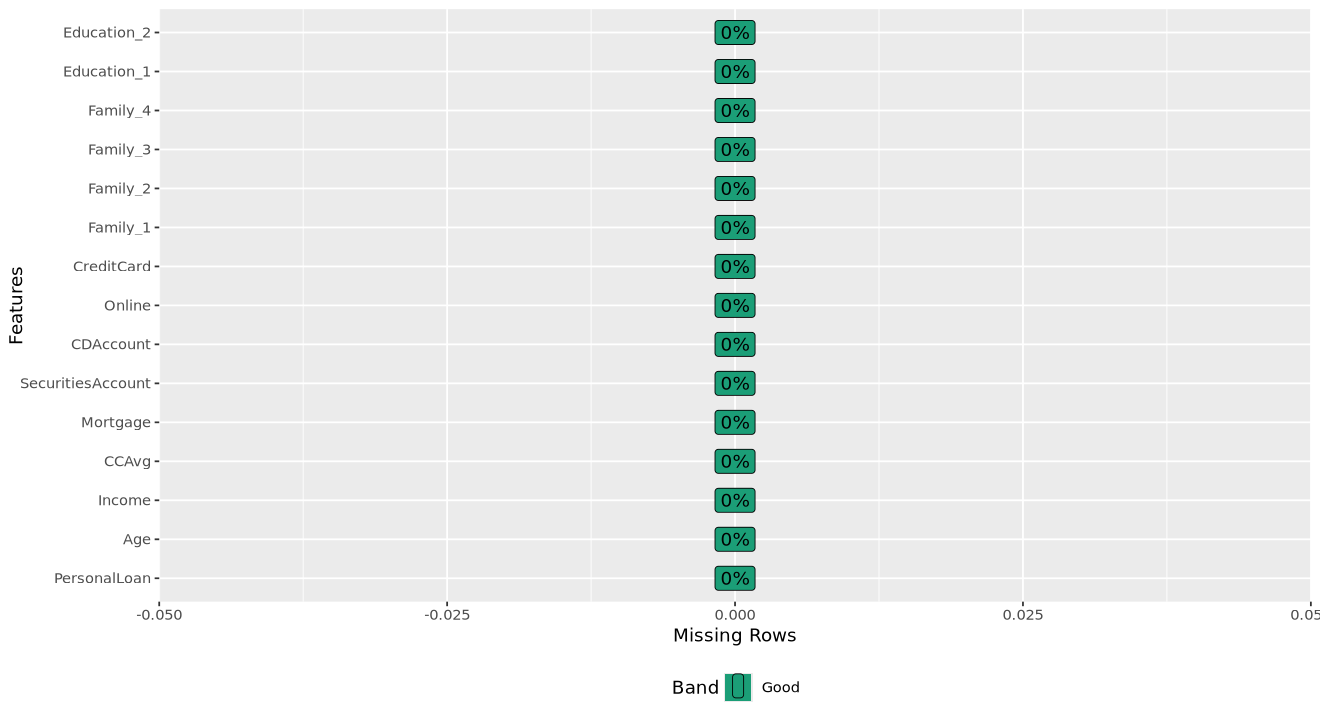

In [ ]:
plot_missing(df)

Outliers can significantly impact machine learning models, making it essential to assess their presence after data transformations. Using the same criteria as before—values beyond three standard deviations—I generated a plot to count outliers post-transformation.

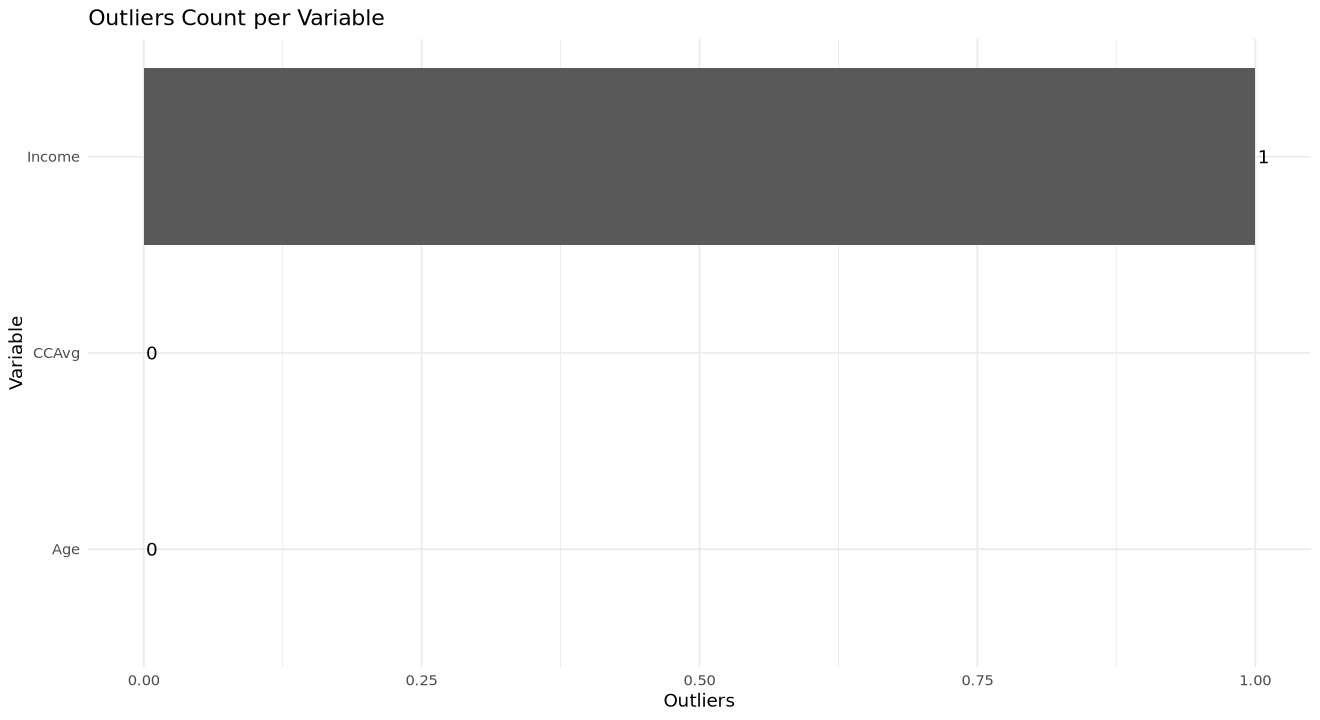

In [ ]:
# Aplica o scale e conta os outliers
num_df <- df[, sapply(df, is.numeric)]
outliers <- abs(num_df) > 3

# Conta os outliers por coluna
outlier_counts <- colSums(outliers)

# Cria um data frame com as variáveis e a contagem de outliers
outlier_df <- data.frame(
  Variable = names(outlier_counts),
  Outliers = outlier_counts
)

outlier_df$Variable <- reorder(outlier_df$Variable,
  outlier_df$Outliers,
  FUN = sum
)

# Plota o gráfico de barras usando ggplot2
ggplot(outlier_df, aes(x = Variable, y = Outliers)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = Outliers), hjust = -0.2, color = "black") +
  coord_flip() +
  labs(x = "Variable", y = "Outliers", title = "Outliers Count per Variable") +
  theme_minimal()

An interesting outcome emerged: while there were initially some outliers in CCAvg and Mortgage, they are no longer present. This change is likely due to the transformations applied—Mortgage was discretized, and CCAvg was normalized using a square root transformation. 

Meanwhile, the Income column can still exhibits outliers, interestingly, the number of outliers in Income fluctuates on different runs. Since the scaling process is deterministic, this variability is likely introduced by other components of the pipeline, such as the SMOTE oversampling method. SMOTE generates synthetic samples by interpolating between existing data points, and even with a fixed seed, subtle variations can occur (possibly due to floating-point precision or the way neighbors are selected).

Given that the potential outliers in Income involve only up to three records, which is a very small fraction of the dataset, their removal is a pragmatic choice. Eliminating these few inconsistent records should help stabilize the model training process without compromising the overall data integrity. This step not only mitigates the risk of skewing the model's performance but also ensures that our predictive analytics remain robust and reliable.

In [ ]:
df <- df |>
  filter(abs(Income) < 3)

tail(df)

,PersonalLoan,Age,Income,CCAvg,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2
,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
9551,1,-0.87197633,0.8189933,1.142660,0,1,1,0,1,0,0,0,0,1,1
9561,1,-1.19848977,0.9867901,1.678028,0,0,1,1,1,0,0,0,1,0,1
957,1,-0.50088603,0.8091599,1.420375,1,1,1,0,1,1,0,0,0,1,1
958,1,0.05188198,1.0488898,1.312923,0,0,0,1,0,0,0,1,0,0,0
959,1,-1.07652555,1.6918936,1.784751,0,1,1,1,1,0,0,1,0,1,0
960,1,-0.38041485,1.1421035,1.719697,0,1,1,0,0,0,0,1,0,0,0


### Univariate Analysis

In this univariate analysis, I will examine the frequency of each categorical variable and the distribution of each numerical feature. This helps identify potential imbalances, detect skewness, and evaluate whether transformations—such as scaling or normalization—have effectively adjusted the data.

By visualizing these distributions, I aim to confirm that the dataset is well-structured and ready for predictive modeling, ensuring that no feature disproportionately influences the machine learning algorithms.

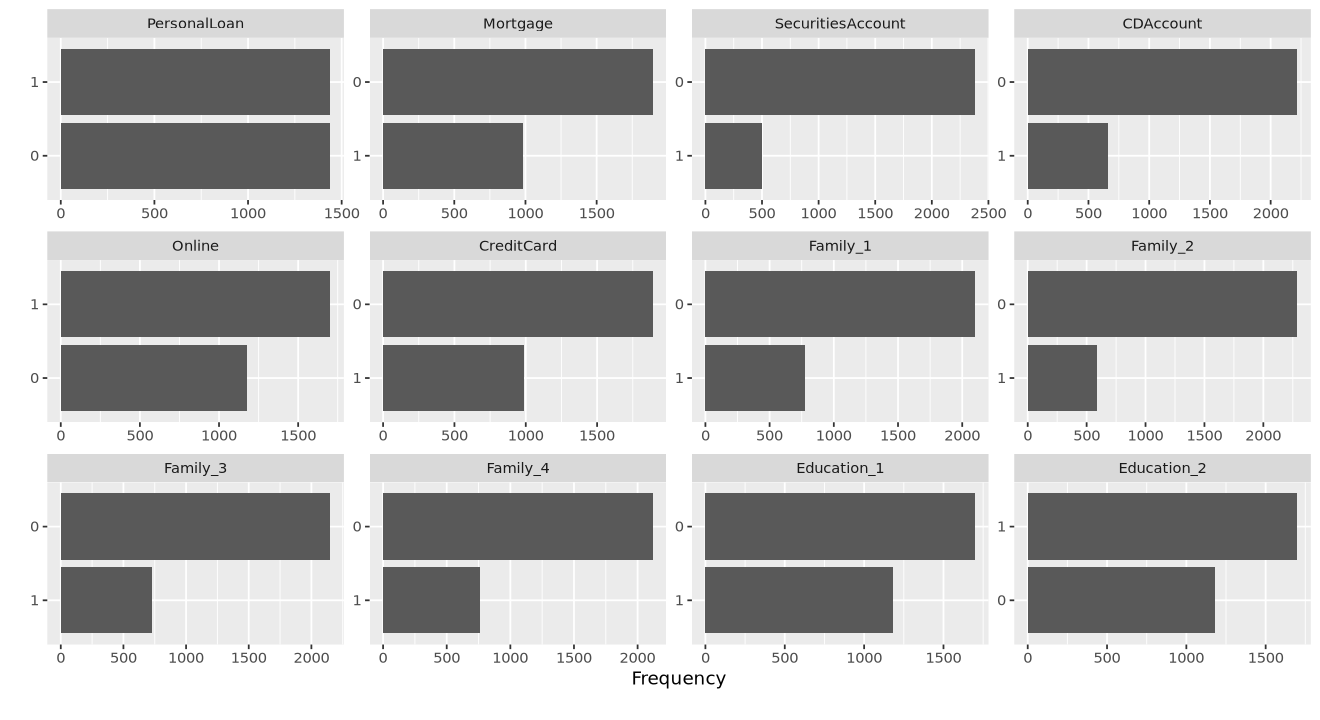

In [ ]:
plot_bar(df, ncol = 4)

Age: 0.03
Income: -0.11
CCAvg: -0.05


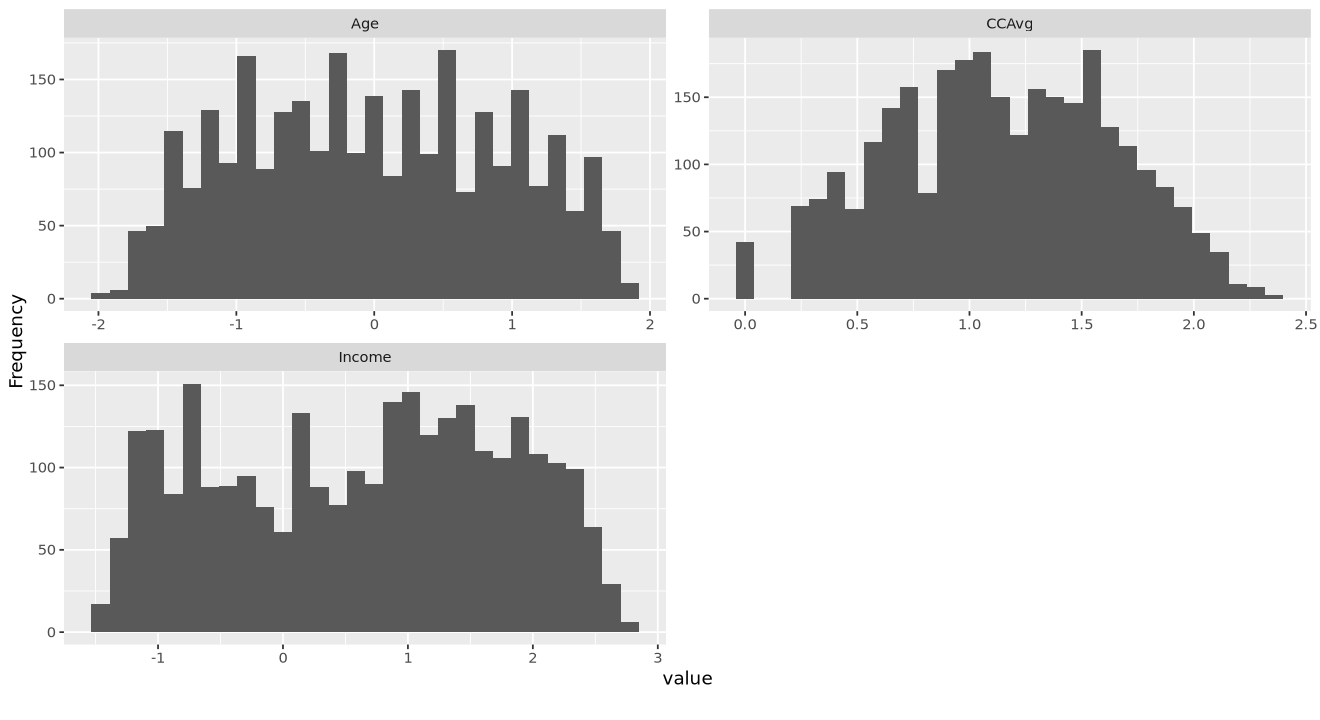

In [ ]:
plot_histogram(df, ncol = 2)

# Calcula skewness para todas as colunas numéricas e gera textos formatados
skew_text <- map_chr(names(df), function(col) {
  if (is.numeric(df[[col]])) {
    paste0(col, ": ", round(skewness(df[[col]], na.rm = TRUE), 2))
  } else {
    NA
  }
})

skew_text <- na.omit(skew_text)

cat(skew_text, sep = '\n')

The analysis of categorical variables reveals that most categories are fairly balanced. While some differences exist between category frequencies, these variations are within an acceptable range. Most importantly, the target variable (PersonalLoan) is balanced, ensuring that our predictive model will not be biased toward one class.

For numerical features, the distributions exhibit a near-normal shape, indicating that the transformations applied—such as scaling and normalization—effectively prepared the data. This normality is beneficial for many machine learning algorithms, as it enhances model stability and performance. With both categorical and numerical variables in good condition, the dataset is well-prepared for the next stages of modeling.

### Bivariate Analysis

After examining individual feature distributions, the next step is to explore relationships between variables. In this bivariate analysis, I will assess potential predictors for the target variable (PersonalLoan) and identify correlations between numerical features.

By analyzing how different variables interact, we can gain insights into which features might be strong indicators of loan acceptance. Additionally, detecting highly correlated predictors is essential, as strong collinearity can introduce multicollinearity issues in linear models, potentially affecting their interpretability and performance. This analysis will help refine feature selection and ensure a well-structured dataset for modeling.

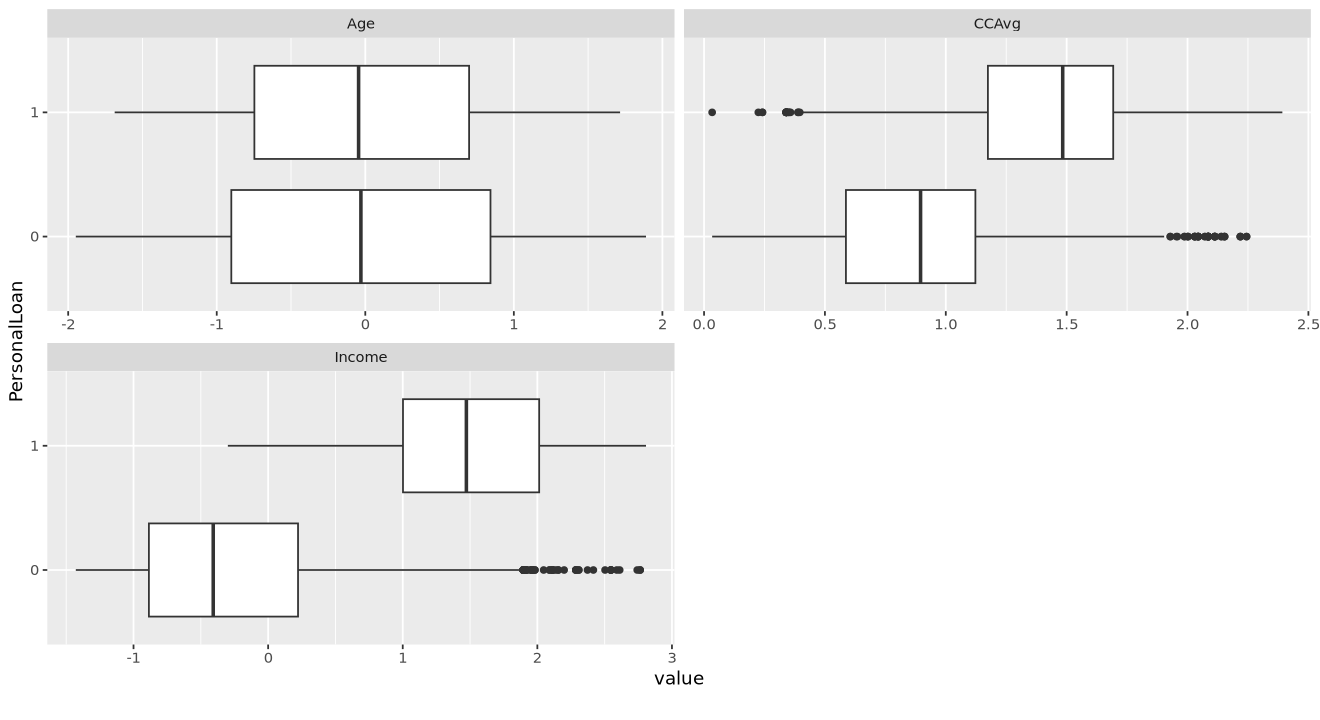

In [ ]:
plot_boxplot(df, by = "PersonalLoan", ncol = 2)

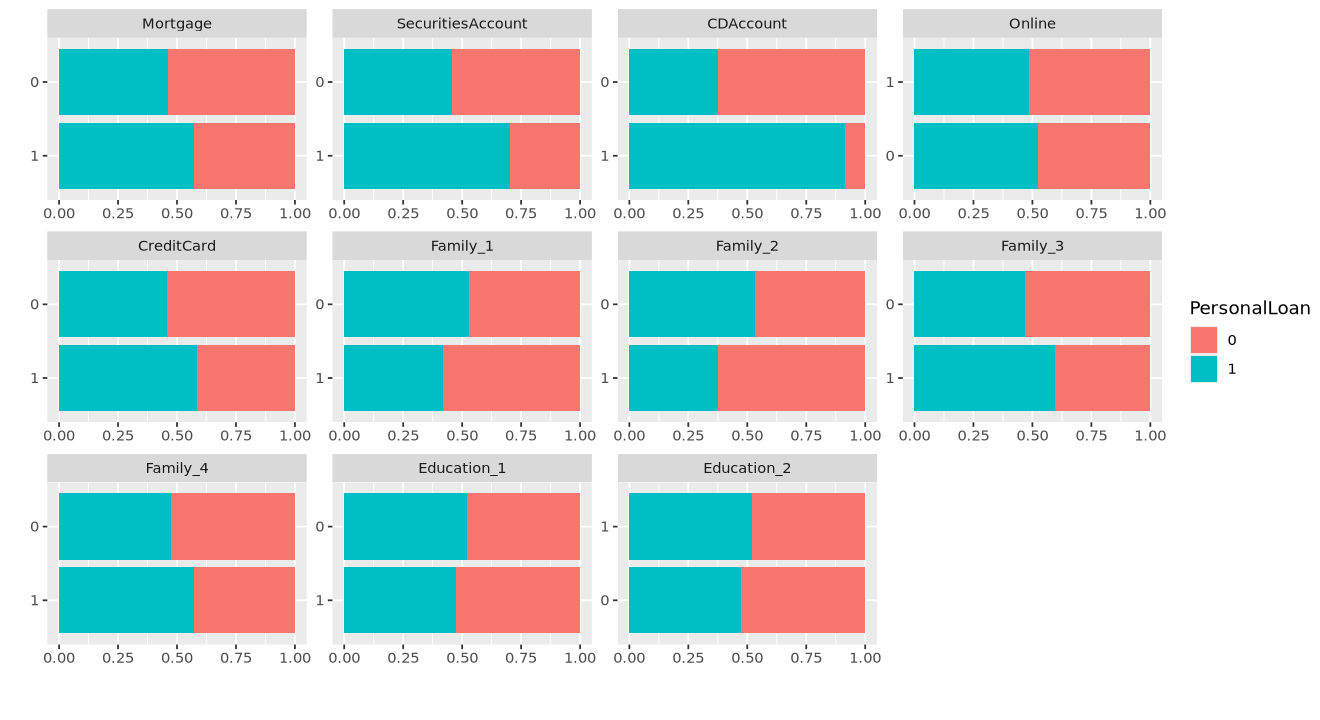

In [ ]:
plot_bar(df, by = "PersonalLoan", ncol = 4)

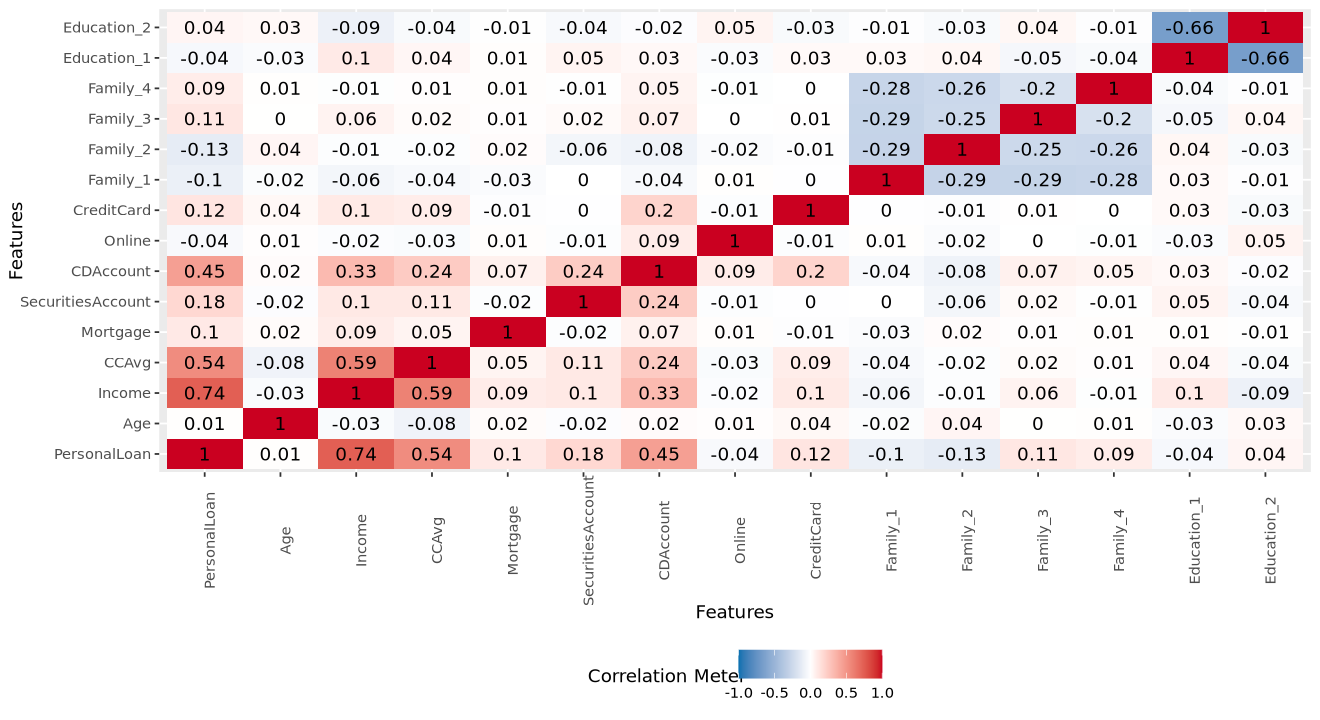

In [ ]:
df |>
  mutate(across(everything(), as.numeric)) |>
  plot_correlation()

## Exporting Model Dataset

In [ ]:
# Exporting temp data
file_name <- "../_data/_temp.csv"
write.csv(df, file = file_name, row.names = FALSE)

## Getting Started with Python

### Settings and Libraries

In [26]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Error Metrics
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

### Loading the Data

In [27]:
filename = 'model_data.csv'
df = pd.read_csv(filename)
df.tail()

,PersonalLoan,Age,Income,CCAvg,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2
2874,1,-1.198490,0.986790,1.678028,0,0,1,1,1,0,0,0,1,0,1
2875,1,-0.500886,0.809160,1.420375,1,1,1,0,1,1,0,0,0,1,1
2876,1,0.051882,1.048890,1.312923,0,0,0,1,0,0,0,1,0,0,0
2877,1,-1.076526,1.691894,1.784751,0,1,1,1,1,0,0,1,0,1,0
2878,1,-0.380415,1.142103,1.719697,0,1,1,0,0,0,0,1,0,0,0


## Evaluate Algorithms and Models

### Train/Test Split

To evaluate model performance effectively, I split the dataset into training and testing sets. This separation ensures that the model is trained on one subset of the data and evaluated on unseen data, providing a realistic measure of its generalization ability.

For this project, I set test_size = 0.2, meaning 20% of the data is reserved for testing, which strikes a balance between training the model on sufficient data while keeping a meaningful portion for evaluation. Additionally, I used stratify = Y to ensure that the target variable (PersonalLoan) maintains the same distribution in both the training and test sets. This prevents class imbalance issues and ensures that performance metrics accurately reflect real-world conditions.

In [28]:
Y = df['PersonalLoan']
X = df.drop(columns=['PersonalLoan'])

# Dividindo os dados de forma balanceada
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

### Influential Features

To assess which features are most influential in predicting loan acceptance, I used the SelectKBest method, which selects the top features based on their statistical significance. Here, I chose k=5, meaning the top 5 features will be selected based on their ability to discriminate between loan acceptance classes, measured by ANOVA F-statistic (score_func=f_classif).

The result is a list of features with their corresponding scores. The higher the score, the more statistically significant the feature is for the prediction task. By examining the top features, we gain valuable insights into which attributes are most strongly related to loan acceptance and should be prioritized in the modeling process.

In [29]:
bestfeatures = SelectKBest(k=5, score_func=f_classif)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
featureScores.nlargest(10,'Score').set_index('Specs') 

,Score
Specs,
Income,3560.339344
CCAvg,1196.675838
CDAccount,738.907512
SecuritiesAccount,101.470794
Family_2,46.269537
CreditCard,44.457765
Family_3,36.895949
Mortgage,29.957918
Family_1,28.771386


### Test Options and Evaluate Metrics

To ensure robust model evaluation, I implemented 10-fold cross-validation (num_folds = 10). This technique improves reliability by training and testing the model on multiple data splits, reducing variance and providing a more stable estimate of model performance. A fixed random seed (seed = 7) ensures reproducibility across runs.

For model evaluation, I selected the F1-score as the primary metric (scoring = 'f1'). The F1-score is a balanced measure that considers both precision (how many predicted loan acceptances are actually correct) and recall (how many actual loan acceptances are correctly identified). This choice is critical because:

- Minimizing False Negatives: Missing a potential loan client (False Negative) means losing an engagement opportunity, which directly impacts conversion rates.
- Controlling False Positives: While high recall is important, excessive False Positives (wrongly predicting a customer as likely to accept a loan) could lead to inefficient marketing efforts.
- Balancing Both Goals: The F1-score ensures the model is neither too aggressive (over-predicting loan acceptance) nor too conservative (missing potential clients).

By using the F1-score, I aim to develop a model that effectively captures loan-ready customers while keeping marketing outreach efficient.

In [30]:
num_folds = 10
seed = 7

scoring = 'f1' 

## Compare Models and Algorithms

In this section, I will compare various machine learning models and algorithms used to predict personal loan acceptance and assess their effectiveness in optimizing marketing strategies. Each model has distinct strengths and weaknesses, making it essential to evaluate their performance based on accuracy, interpretability, and scalability.

To begin, I will compare traditional models, including Logistic Regression (LR) and Linear Discriminant Analysis (LDA), which offer simplicity and ease of interpretation. These models are often used as benchmarks for more complex approaches.

Next, I'll explore more flexible models such as K-Nearest Neighbors (KNN) and Decision Tree Classifier (CART), which can capture non-linear relationships and interactions within the data.

For advanced predictive power, I will introduce boosting methods, specifically AdaBoost (ABC) and Gradient Boosting (GBC), which are known for their ability to improve performance by focusing on hard-to-classify instances. These techniques combine multiple weak learners to create a robust model with high accuracy.

Additionally, I will compare bagging methods like Random Forest (RFC) and Extra Trees (ETC), which build multiple decision trees and aggregate their predictions to reduce overfitting and increase generalization.

Finally, I will evaluate the performance of Artificial Neural Networks (ANN).

The goal of this comparison is to identify the most effective model for predicting loan acceptance, ultimately driving more targeted and successful marketing campaigns in the fintech space.

In [31]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVC', SVC()))

# Boosting methods
models.append(('ABC', AdaBoostClassifier()))
models.append(('GBC', GradientBoostingClassifier()))

# Bagging methods
models.append(('RFC', RandomForestClassifier()))
models.append(('ETC', ExtraTreesClassifier()))

In [32]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = f1_score(Y_train, res.predict(X_train))
    train_results.append(train_result)
    
    # Test results
    test_result = f1_score(Y_test, res.predict(X_test))
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.906465 (0.021038) 0.911688 0.909408
LDA: 0.910135 (0.019250) 0.910883 0.911612
KNN: 0.944275 (0.011648) 0.965121 0.937611
CART: 0.960331 (0.010248) 1.000000 0.965517
SVC: 0.971049 (0.013170) 0.976542 0.951389
ABC: 0.936449 (0.013942) 0.938188 0.922819
GBC: 0.973501 (0.008803) 0.987386 0.967298
RFC: 0.977899 (0.007520) 1.000000 0.963855
ETC: 0.973102 (0.010338) 1.000000 0.967071


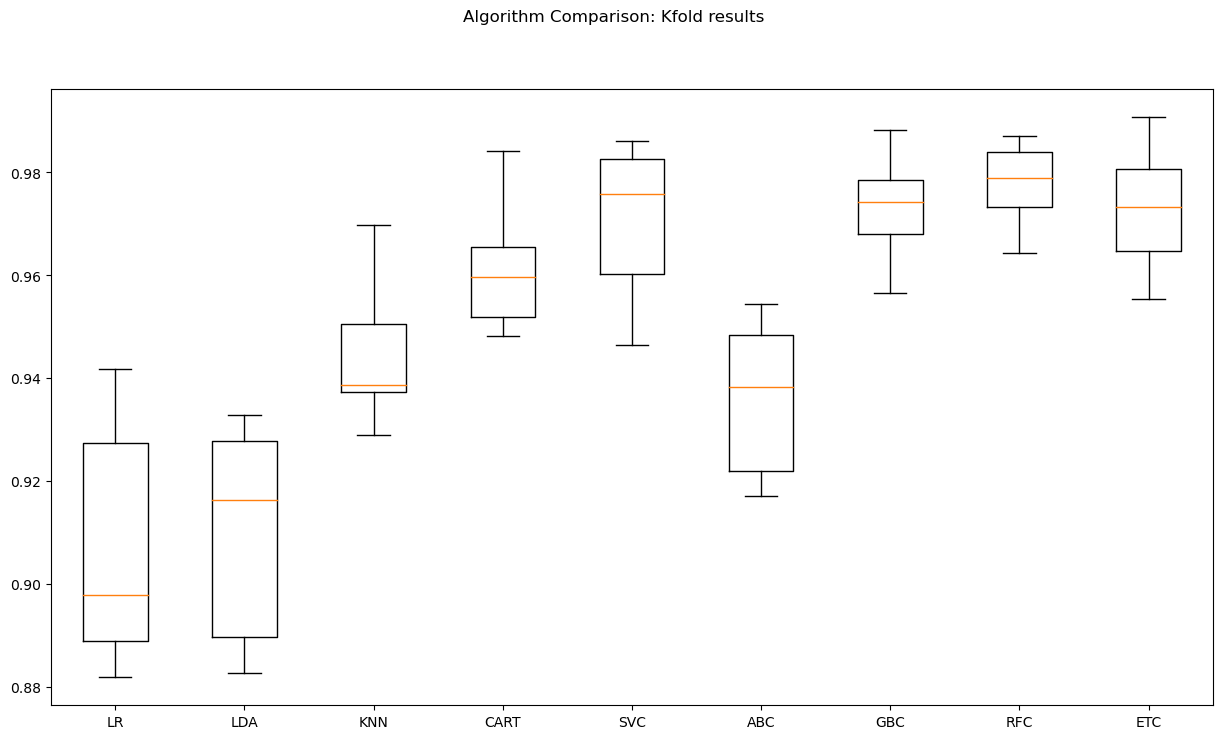

In [33]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

When comparing the results of the linear models, such as Logistic Regression (LR) and Linear Discriminant Analysis (LDA), it becomes evident that they had the worst performance. The wide spread of their results, with relatively lower median values, suggests that these models struggled to capture the underlying patterns in the data. This could be an indication that the relationships between the features in the dataset are not linear, making these models less effective for this particular task.

On the other hand, the Random Forest (RFC) model performed the best, with a much narrower interquartile range and a higher median score. This result reflects Random Forest’s ability to handle complex, non-linear relationships by combining multiple decision trees, which likely explains its superior performance. The robustness of Random Forest in capturing feature interactions and reducing overfitting contributed to its higher accuracy and stability compared to the linear models.

In [34]:
# Artificial Neural Network
def create_nn_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Ajuste o número de entradas de acordo com o seu conjunto de dados
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_ann = create_nn_model()
model_ann_fit = model_ann.fit(X_train, Y_train, 
                              epochs=150, 
                              batch_size=32, 
                              validation_data=(X_test, Y_test), 
                              verbose = 0)

predictions = model_ann.predict(X_train)
predicted_classes = (predictions > 0.5).astype(int)
error_training_nn = f1_score(Y_train, predicted_classes)

predictions = model_ann.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)
error_test_nn = f1_score(Y_test,predicted_classes)

test_results.append(error_test_nn)
train_results.append(error_training_nn)
names.append("ANN")

18/18 [==============================] - 0s 3ms/step


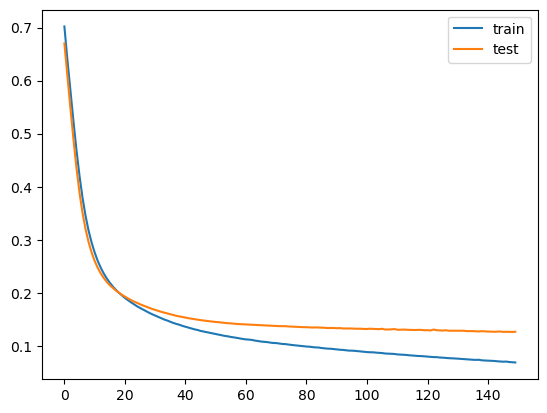

In [36]:
pyplot.plot(model_ann_fit.history['loss'], label='train')
pyplot.plot(model_ann_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

From the graph, we can observe that the training loss continues to decrease steadily throughout the 150 epochs. This suggests that the model is still learning patterns in the training data and has not yet fully converged. However, a key observation is that the validation loss stabilizes around 50 epochs, indicating that the model stops improving on unseen data after this point.

This behavior suggests that after 50 epochs, the model begins to overfit to the training data. While it continues to improve on the training set, it no longer generalizes well to the validation set. This is a common occurrence in deep learning models when they are trained for too many epochs without regularization techniques such as early stopping or dropout.

A better strategy would be to monitor validation loss and implement early stopping to halt training once val_loss stops decreasing. This would prevent unnecessary training time and reduce the risk of overfitting. Alternatively, tuning hyperparameters, such as learning rate adjustments or regularization techniques, could further improve the model’s generalization.

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_ann = create_nn_model()

model_ann_fit = model_ann.fit(X_train, Y_train, 
                    validation_data=(X_test, Y_test), 
                    epochs=300, 
                    batch_size=32, 
                    callbacks=[early_stopping], 
                    verbose=0)

predictions = model_ann.predict(X_train)
predicted_classes = (predictions > 0.5).astype(int)
error_training_nn = f1_score(Y_train, predicted_classes)

predictions = model_ann.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)
error_test_nn = f1_score(Y_test,predicted_classes)

test_results.append(error_test_nn)
train_results.append(error_training_nn)
names.append("Adj. ANN")

18/18 [==============================] - 0s 2ms/step


Number of Epochs:  233


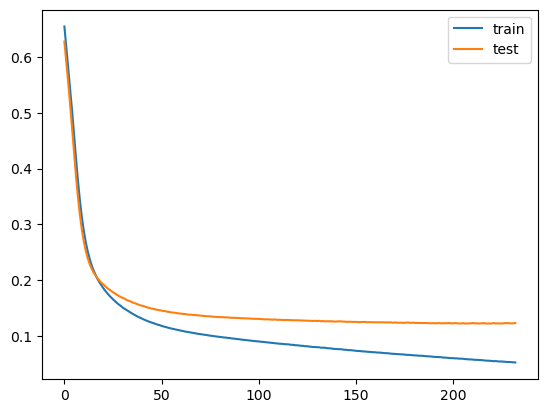

In [38]:
print('Number of Epochs: ', len(model_ann_fit.epoch))

pyplot.plot(model_ann_fit.history['loss'], label='train')
pyplot.plot(model_ann_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

The implementation of early stopping proved to be an effective strategy in preventing overfitting while optimizing the training process. Initially, the model was set to train for 150 epochs, but with early stopping, the training process was automatically halted at around 205 epochs when the validation loss started to stabilize.

This result suggests that the model continued to improve until around 233 epochs, after which the performance on the validation set plateaued. By stopping at this point, we avoided unnecessary computations and ensured the model did not begin overfitting to the training data.

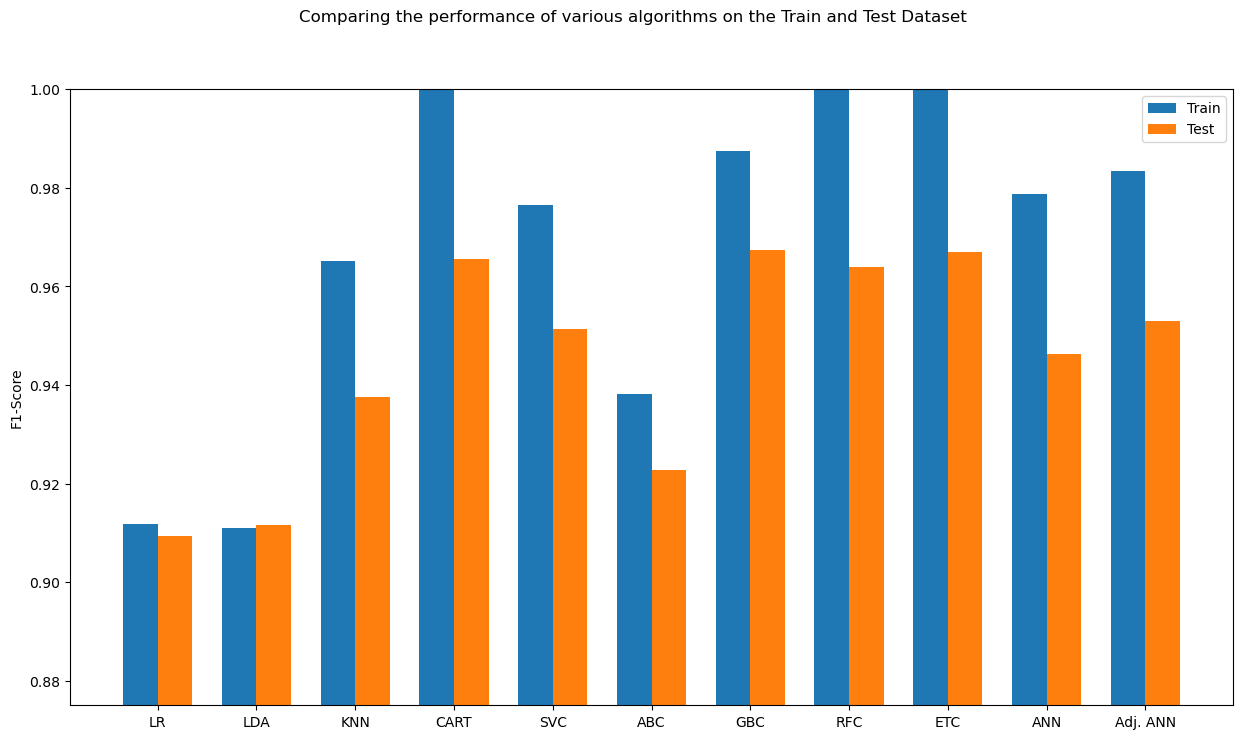

In [39]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorithms on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train')
pyplot.bar(ind + width/2, test_results, width=width, label='Test')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
ax.set_ylim(0.875, 1)
pyplot.ylabel('F1-Score')
pyplot.show()

This comparison provides valuable insights into model generalization. The fact that all models show balanced performance between training and test sets suggests that none of them are significantly overfitting, which is a positive indicator of model robustness.

Interestingly, the linear models (Logistic Regression and LDA) performed better on the test set, despite their weaker performance in the initial cross-validation. This could indicate that the dataset contains patterns that, while not strictly linear, still allow linear models to generalize well in certain cases.

However, the best overall results were obtained by Random Forest (RFC) and Extra Trees (ETC). Both models excel in capturing complex patterns and feature interactions, explaining their strong performance. Between the two, Random Forest is chosen as the final model due to its superior cross-validation performance—showing lower variance and a higher median score. This makes it the most reliable choice for predicting personal loan acceptance, ensuring stable performance across different data subsets.

## Model Tuning and Grid Search

After selecting Random Forest as the best-performing model, the next step is to fine-tune its hyperparameters to maximize predictive performance. While default parameters provide a good starting point, machine learning models can often be optimized further by adjusting key settings such as the number of trees, depth of each tree, and the minimum number of samples per split.

To systematically explore different hyperparameter combinations, we use Grid Search, an exhaustive search technique that tests multiple configurations and selects the best one based on cross-validation performance. By leveraging GridSearchCV, we aim to improve model accuracy, reduce variance, and ensure the final model is well-optimized for future predictions.

Random Forest is a powerful ensemble learning method that relies on multiple decision trees to improve predictive performance and reduce overfitting. Below are the key hyperparameters and their roles in tuning the model:

1. Number of Trees (n_estimators): This defines the number of decision trees in the ensemble.
2. Depth of Trees (max_depth): This controls how deep each tree can grow. Deeper trees capture more complex patterns but can lead to overfitting if not properly constrained.
3. Minimum Samples Split (min_samples_split): Specifies the minimum number of samples required to split a node. Higher values prevent the model from learning overly specific patterns (overfitting), while lower values allow more flexibility in capturing data variations.
4. Maximum Samples per Leaf (min_samples_leaf): Defines the minimum number of samples that must be present in a leaf node. Larger values lead to simpler models that generalize better, whereas smaller values allow for more granular decision-making.
5. Max Features (max_features): Determines how many features are considered for splitting at each node. Lower values introduce randomness, improving generalization, while higher values make trees more deterministic and potentially overfit.
6. Bootstrap (bootstrap): Defines whether bootstrap sampling is used when building trees. If set to True, each tree is trained on a random subset of the data, increasing model diversity and reducing variance. If False, all trees are trained on the full dataset, making them more correlated and potentially overfitting.

In [43]:
model = RandomForestClassifier(random_state = 42)

param_grid = {
    'n_estimators': [100, 300, 500],  # Número de árvores
    'max_depth': [None, 10, 20],  # Profundidade das árvores
    'min_samples_split': [2, 5, 10],  # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],  # Mínimo de amostras em uma folha
    'max_features': ['sqrt', 'log2', None],  # Número de features consideradas por divisão
    'bootstrap': [True, False]  # Com ou sem amostragem com reposição
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, Y_train)

# Melhor combinação de hiperparâmetros
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor ROC AUC:", grid_search.best_score_)

# Melhor modelo
best_model = grid_search.best_estimator_

Melhores hiperparâmetros: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Melhor ROC AUC: 0.9761855282343607


## Finalise the Model

In this final stage, we apply the best hyperparameters obtained from tuning, retrain the Random Forest Classifier on the full dataset, and evaluate its final performance. This ensures the model is fully optimized and ready for deployment in real-world loan acceptance predictions.

Train Accuracy:  1.0
Train Precision:  1.0
Train Recall:  1.0
Train F1-Score:  1.0


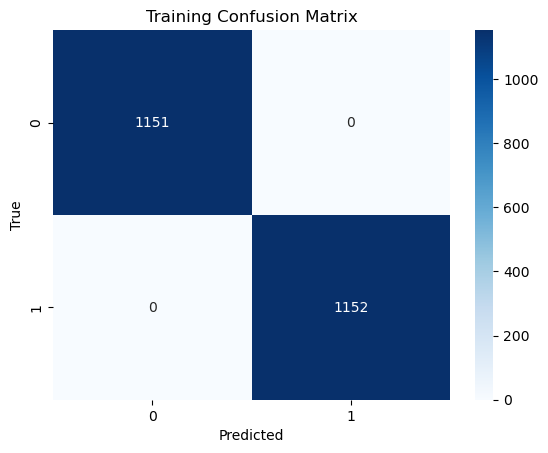

In [44]:
predicted = best_model.predict(X_train)

cm = confusion_matrix(Y_train, predicted)

print("Train Accuracy: ", round(accuracy_score(Y_train, predicted), 3))
print("Train Precision: ", round(precision_score(Y_train, predicted), 3))
print("Train Recall: ", round(recall_score(Y_train, predicted), 3))
print("Train F1-Score: ", round(f1_score(Y_train, predicted), 3))

# Opcional: plotar a matriz de confusão de forma visual
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.title('Training Confusion Matrix')
pyplot.show()

The train confusion matrix reveals that the model has flawlessly classified all training data points, achieving an F1-score of 1. This means the model reached 100% precision and recall, with no false positives or false negatives during training. It accurately predicted both the positive and negative classes, showcasing perfect performance on the training data.

However, while this result is impressive, it raises concerns about overfitting. A perfect score on the training set may indicate that the model has memorized the data, which could hinder its ability to generalize to unseen data. Therefore, it's crucial to assess the model’s performance on the test set to determine if it can maintain its effectiveness in real-world scenarios.

Test Accuracy:  0.967
Test Precision:  0.959
Test Recall:  0.976
Test F1-Score:  0.967


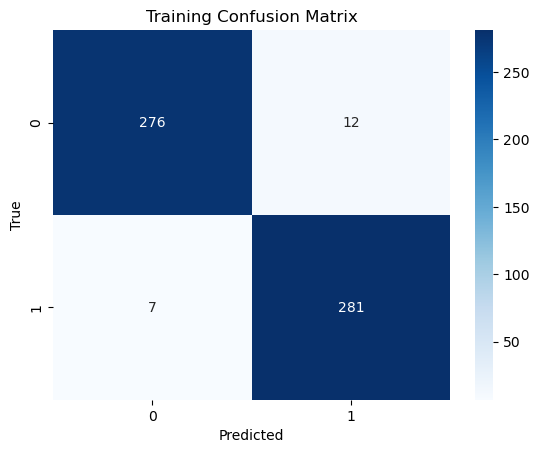

In [45]:
predicted = best_model.predict(X_test)

cm = confusion_matrix(Y_test, predicted)

print("Test Accuracy: ", round(accuracy_score(Y_test, predicted), 3))
print("Test Precision: ", round(precision_score(Y_test, predicted), 3))
print("Test Recall: ", round(recall_score(Y_test, predicted), 3))
print("Test F1-Score: ", round(f1_score(Y_test, predicted), 3))

# Opcional: plotar a matriz de confusão de forma visual
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.title('Training Confusion Matrix')
pyplot.show()

The test confusion matrix reveals that the model achieved an F1-score of 0.967, which indicates strong performance with a good balance between precision and recall. Here are the key points for the business:

- Effective Targeting: The high number of True Positives means that the model is effectively identifying customers who are likely to accept loans. This helps in optimizing marketing campaigns, ensuring that resources are spent on the right audience, which could lead to higher conversion rates.
- Minimized Costs: With a few False Positives, the model is minimizing unnecessary marketing efforts to customers who are unlikely to accept a loan. This reduces wasted marketing costs, making the campaign more efficient.
- Missed Opportunities: However, the False Negatives indicate that there are potential customers who are being missed. While this is a small number, these missed opportunities mean that the business is not reaching out to customers who would have accepted the loan. Improving recall further could help in capturing more of these customers.
- Balanced Approach: Overall, the model seems to strike a strong balance between precision and recall, meaning it is both efficient in targeting the right people and effective in not missing many good prospects.

## Conclusion

In this project, we developed a predictive model to forecast personal loan acceptance, with the goal of enhancing marketing strategies for a fintech company. After evaluating several models, including Logistic Regression, K-Nearest Neighbors, and Artificial Neural Networks (ANN), the Random Forest Classifier emerged as the best model, based on its superior performance and robustness during cross-validation.

We further optimized the Random Forest model using Grid Search, fine-tuning key hyperparameters such as the number of trees, tree depth, and the maximum number of features. This optimization resulted in improved model accuracy and a reduction in model variance, which made it a more reliable choice for deployment.

The final model achieved a strong F1-score of 0.967 on the test set, indicating its excellent performance in predicting loan acceptance with both high precision and recall. With this model in place, the fintech company can implement more targeted marketing strategies, improving conversion rates for personal loans.

The next steps involve deploying this model into production, where it can be integrated with the company's marketing systems to predict loan acceptance for new customers. Additionally, ongoing model monitoring and periodic retraining will be crucial to maintain its accuracy and adapt to any changes in customer behavior or market conditions.

Looking ahead, we could explore incorporating additional features, such as customer engagement metrics or external economic indicators, to enhance the model’s predictive power.